# Network Analysis of the Atrioventricular Node

We use ideas from network science on the atrioventricular (AV) node, and produce a network based on a sampled set of regions on the AV node. A matrix is constructed based on the means of these regions (which we select using squares), where each column represents a region of the AV node and each row represents the mean at a certain point of time (or frame). The matrix is then standardised, and the first principal component is removed using principal component analysis (PCA) (if desired). A correlation matrix is then constructed from the standardised matrix (or reconstructed matrix after PCA). A network is then constructed based on satisfying a certain target mean degree, by selecting a correlation threshold appropriately. An edge between a pair of points is then included in the network, if the correlation between the two points meets this correlation threshold. Statistics, such as the clustering coefficient and small-world coefficient, are calculated and appended to a .csv file for analysis.

This notebook was developed in support of an academic paper, and an abstract of the paper (presented at the Biophysical Society Meeting 2024) can be found [here](https://doi.org/10.1016/j.bpj.2023.11.2779).

This notebook is part of the [av-node-analysis](https://github.com/yasirbarlas/av-node-analysis) Github repository.

In [1]:
# Import libraries to be used later
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import cv2
import os
import tifffile # if using .tif
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit
import scipy.stats as stats
from scipy.special import gamma
import random
import math
import csv

In [2]:
# We assume you will be working with a '.tif' file and that you have already performed motion correction with CaImAn if needed (see Github repository)

# Set directory to the relevant '.tif' file
tif_file_name = "../directory/1894_s5_corrected.tif"

tif_array = tifffile.imread(tif_file_name)

# Convert the 3D array to a list of 2D arrays (frames)
frame_list = [frame for frame in tif_array]

In [3]:
# Define function to draw squares on video
def calculate_and_draw_points(frames, radius, num_points, min_distance, margin, square_size, frame_height = None, frame_width = None):
    ex = frames.copy() # Copy frames
    num_frames = len(ex) # Number of frames in the video
    frame0_height, frame0_width = ex[0].shape # Dimensions of a single frame (and thus the other frames)

    # If no frame height manually given, use height from input frames
    if frame_height is None:
        frame_height = frame0_height

    # If no frame width manually given, use width from input frames
    if frame_width is None:
        frame_width = frame0_width

    # Get the coordinates of the (randomly) chosen points, and append them to a list
    chosen_points = []
    # Select points ensuring the minimum distance between them
    while len(chosen_points) < num_points:
        x = np.random.randint(margin, frame_height - margin)
        y = np.random.randint(margin, frame_width - margin)
        # Check if the new point is far enough from existing chosen points
        if all(np.linalg.norm(np.array([x, y]) - np.array(point)) > min_distance for point in chosen_points):
            chosen_points.append((x, y))
            
    chosen_points = np.array(chosen_points).T

    # Calculate mean intensities
    results = []
    for frame_num, frame in enumerate(ex):
        means = []
        for i, point in enumerate(zip(chosen_points[0], chosen_points[1])):
            x, y = point # Coordinates of the point
            # Define the region around the point
            x_start = max(0, x - radius)
            x_end = min(square_size, x + radius + 1)
            y_start = max(0, y - radius)
            y_end = min(square_size, y + radius + 1)
            pixel_region = frame[x_start:x_end, y_start:y_end] # Extract the pixel region

            # Calculate the mean intensity of the region and append to list
            mean_intensity = np.mean(pixel_region)
            means.append(mean_intensity)

        # Append results to dictionary
        results.append({
            "frame": frame_num,
            "points": chosen_points,
            "means": means,
            "drawn_frame": frame
        })

    # Draw squares on the frames (done separately to prevent the drawn squares from being used in the mean calculations)
    for frame_num, frame in enumerate(ex):
        for i, point in enumerate(zip(chosen_points[0], chosen_points[1])):
            # Get point
            x, y = point

            # Define the coordinates of the square
            x1 = max(0, y - radius)
            y1 = max(0, x - radius)
            x2 = min(square_size - 1, y + radius)
            y2 = min(square_size - 1, x + radius)
            # Draw the rectangle on the frame
            cv2.rectangle(frame, (x1, y1), (x2, y2), (165, 165, 0), 2)
            
            # Annotate the square with its number
            #cv2.putText(frame, str(i + 1), (y - 5, x + 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2) # uncomment if desired

        # Update the results dictionary with the frame with the squares overlaid
        results[frame_num].update({"drawn_frame": frame})
        
    return results

In [4]:
# Hyperparameters for the 'calculate_and_draw_points()' function
radius = 10 # Square radius
num_points = 150 # Number of points to sample from frames
min_distance = 30 # Minimum distance from the centre of a square 'i' to a square 'j' (do not let squares overlap each other)
margin = 15 # Minimum margin from the edges of the frame (do not select points close to the edge of the frame)
square_size = 512 # Square size
frame_height = 465 # Manual frame height, 'None' if using default size from frames
frame_width = None # Manual frame width, 'None' if using default size from frames

(512, 512)
Frame:  0
Points (x, y):  [[426 112 428  29 367 260 130 377 207 235  74 347  59 336 182 246 351 100
   87 206 125 174 216 311 321 361 425  71 441 306 300  20 379  50 166 205
  117 265 352 319 156 109 407 288 420 368 194  87 271 127 257  47 313 175
  395 261  92  31 395 227 367 148 162  52  74 334 297  22 242  41 332  58
  222 293 292 358 241 123 279 107  44 171 239 431  70 212  55 239 290  17
   59 395 101 179 335 340 213 433 139 370 138 260  89  80 422 158 449 215
  200  23 288  94  16  18 148 387 393 378 371 326 427 329  44 246  22 140
  419 427 274 194 447 445 400 161 180 139 192 405 231 204 106  22 318 320
  449  15 129 414 327 408]
 [465 144 401 146 330 169  82 402 227 436 209  44 264 316  47  77 423  59
  122 320 356 326 493 440 109 180 287 350 223 314 133 111  44 441 417 268
  428 122 453  65 162 223 326 418  60 483 405 406 225 194 270 235 473 244
  260 452 264 298 165  33 231  29 196 404 319 379 185 402 310 198 251  35
  189 374 274  78 142 481 340 330 480 476 395 36

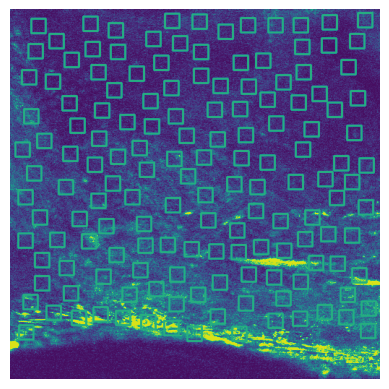

In [5]:
# Convert these frames to arrays
dataset_array = [np.array(img) for img in frame_list]

# Set a random seed for reproducibility
np.random.seed(5000)

# Calculate and draw points on the video (change hyperparameters as desired)
results = calculate_and_draw_points(frames = dataset_array, radius = radius, num_points = num_points, min_distance = min_distance, margin = margin, square_size = square_size, frame_height = frame_height, frame_width = frame_width)

# Confirm shape is as expected (512 x 512)
print(results[0]["drawn_frame"].shape)

# Example of first frame
print("Frame: ", results[0]["frame"])
print("Points (x, y): ", results[0]["points"])
print("Means: ", results[0]["means"])
plt.imshow(results[0]["drawn_frame"])
plt.axis("off")
plt.show()

In [6]:
# Create a matrix to store the mean values
matrix = np.zeros((len(results), num_points))

# Extract the mean values from the results
for i, result in enumerate(results):
    means = result["means"]
    matrix[i, :] = means

# Display matrix
print(matrix.shape)
print(f"Matrix of means for each square:\n {matrix}")

(202, 150)
Matrix of means for each square:
 [[100.68801496  17.33645996  81.54711185 ... 122.642923    69.78319624
   85.47163748]
 [112.01790402  16.68621747  87.36409577 ... 127.30922412 108.15441104
   89.19803069]
 [104.34942202  15.60145298  77.28568396 ... 121.84759711  96.16059762
   88.80331225]
 ...
 [ 94.37028465  16.13610975  79.44148466 ... 113.50504308  66.95494722
   82.09849312]
 [ 94.54571453  16.57131551  79.09495492 ... 118.01752982  72.02160295
   85.05960908]
 [108.71444036  16.3131886   81.98333729 ... 119.54059275 106.54342233
   89.27832501]]


In [7]:
# Standardise matrix and perform PCA
standscale = StandardScaler().fit_transform(matrix)
pca = PCA()
# Fit the PCA model to the data
pca.fit(standscale)

print(f"Explained Variance Ratio of 5 components: {pca.explained_variance_ratio_[0:5]}")
first_component_variability = pca.explained_variance_ratio_[0]
second_component_variability = pca.explained_variance_ratio_[1]
print("First Component Variability:", first_component_variability)
print("Second Component Variability:", second_component_variability)

Explained Variance Ratio of 5 components: [0.32979199 0.11686657 0.05585608 0.04190036 0.02115514]
First Component Variability: 0.3297919895308153
Second Component Variability: 0.11686657273024166


In [8]:
# Compute the correlation matrix (columns are the variables)
correlation_matrix = np.corrcoef(standscale, rowvar = False)
print(correlation_matrix.shape)
print(f"Correlation Matrix (centered and scaled):\n {correlation_matrix}")

(150, 150)
Correlation Matrix (centered and scaled):
 [[ 1.         -0.1445989   0.5458331  ...  0.49679048  0.46869275
  -0.30590137]
 [-0.1445989   1.         -0.07399453 ... -0.14273958 -0.03800398
   0.07312696]
 [ 0.5458331  -0.07399453  1.         ...  0.32667705  0.21348243
  -0.22912859]
 ...
 [ 0.49679048 -0.14273958  0.32667705 ...  1.          0.21890838
  -0.22029323]
 [ 0.46869275 -0.03800398  0.21348243 ...  0.21890838  1.
   0.55876635]
 [-0.30590137  0.07312696 -0.22912859 ... -0.22029323  0.55876635
   1.        ]]


In [9]:
def calculate_ipr(eigenvectors):
    li = []
    for i in eigenvectors:
        ipr = sum((i / np.linalg.norm(i))**4)
        li.append(ipr)
    return li

principal_components = pca.components_
ipr = calculate_ipr(principal_components)

findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not

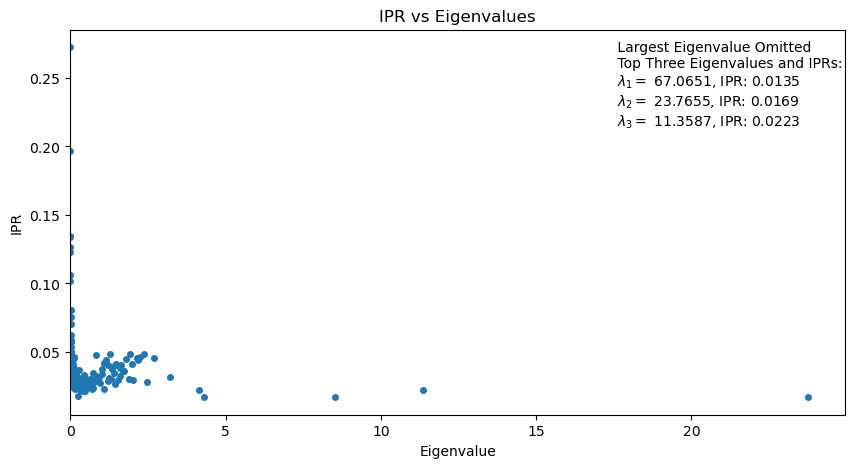

In [10]:
eigenvalues = (pca.singular_values_) * (pca.singular_values_) / (num_points - 1)

plt.figure(figsize = (10, 5))
plt.plot(eigenvalues[1:], ipr[1:], marker = "o", linestyle = "None", markersize = 4)
plt.title("IPR vs Eigenvalues")
plt.xlim(0)
plt.xlabel("Eigenvalue")
plt.ylabel("IPR")
plt.annotate(f" Largest Eigenvalue Omitted \n Top Three Eigenvalues and IPRs: \n $\lambda_{1} = $ {round(eigenvalues[0], 4)}, IPR: {round(ipr[0], 4)} \n $\lambda_{2} = $ {round(eigenvalues[1], 4)}, IPR: {round(ipr[1], 4)} \n $\lambda_{3} = $ {round(eigenvalues[2], 4)}, IPR: {round(ipr[2], 4)}", xy=(0.7, 0.75), xycoords = "axes fraction")
plt.savefig(f"{tif_file_name}_ipr.pdf")
plt.show()

In [11]:
# Number of principal components to remove from data
count = 0

data_without_component = pca.transform(standscale)
data_without_component[:, :count] = 0

reconstructed_data = pca.inverse_transform(data_without_component)
print(f"Principal Components to Remove: {count}")
# Compute the correlation matrix (columns are the variables)
correlation_matrix_reconst = np.corrcoef(reconstructed_data, rowvar = False)
print(correlation_matrix_reconst)

Principal Components to Remove: 0
[[ 1.         -0.1445989   0.5458331  ...  0.49679048  0.46869275
  -0.30590137]
 [-0.1445989   1.         -0.07399453 ... -0.14273958 -0.03800398
   0.07312696]
 [ 0.5458331  -0.07399453  1.         ...  0.32667705  0.21348243
  -0.22912859]
 ...
 [ 0.49679048 -0.14273958  0.32667705 ...  1.          0.21890838
  -0.22029323]
 [ 0.46869275 -0.03800398  0.21348243 ...  0.21890838  1.
   0.55876635]
 [-0.30590137  0.07312696 -0.22912859 ... -0.22029323  0.55876635
   1.        ]]


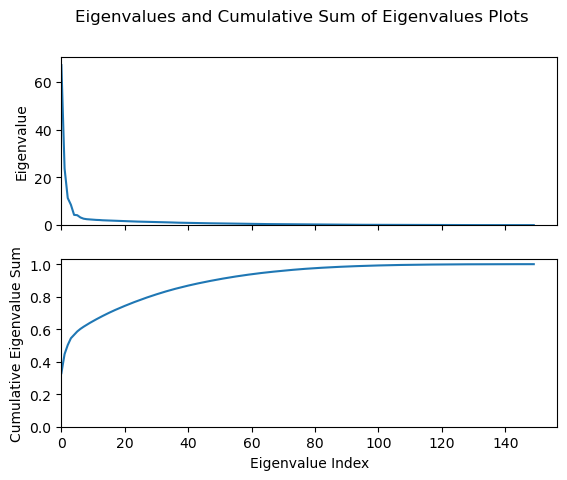

In [12]:
fig, (ax1, ax2) = plt.subplots(2, sharex = True)
fig.suptitle("Eigenvalues and Cumulative Sum of Eigenvalues Plots")

# Plot of eigenvalues
ax1.plot(eigenvalues)
ax1.set_ylim(bottom = 0)
ax1.set_ylabel("Eigenvalue")

if count >= 1:
    ax1.axvline(x = count, color = "r", linestyle = "--", label = "PC1")
    ax1.legend()

# Plot of cumulative sum of eigenvalues
ax2.plot(np.cumsum(pca.explained_variance_ratio_))
ax2.set_ylim(bottom = 0)
ax2.set_xlim(0)
ax2.set_xlabel("Eigenvalue Index")
ax2.set_ylabel("Cumulative Eigenvalue Sum")
plt.savefig(f"{tif_file_name}_eigen_cumul.pdf")
plt.show()

In [13]:
# Generate two lists of x-values and y-values of square centres
x_vals = results[0]["points"][0]
y_vals = results[0]["points"][1]

# Stack so that they are in form (x, y)
points = np.column_stack((x_vals, y_vals))

# Compute the Euclidean distance matrix
distance_matrix = cdist(points, points, metric = "euclidean")
print("\n", distance_matrix.shape)
print(f"Euclidean Distance Matrix (centres of squares):\n {distance_matrix}")


 (150, 150)
Euclidean Distance Matrix (centres of squares):
 [[  0.         449.0400873   64.03124237 ...  33.24154028 295.10167739
  235.68835355]
 [449.0400873    0.         407.3143749  ... 463.79736955 219.25783908
  308.2401661 ]
 [ 64.03124237 407.3143749    0.         ...  96.02603814 236.63685258
  172.16561794]
 ...
 [ 33.24154028 463.79736955  96.02603814 ...   0.         321.01401839
  266.06766057]
 [295.10167739 219.25783908 236.63685258 ... 321.01401839   0.
   91.70605214]
 [235.68835355 308.2401661  172.16561794 ... 266.06766057  91.70605214
    0.        ]]


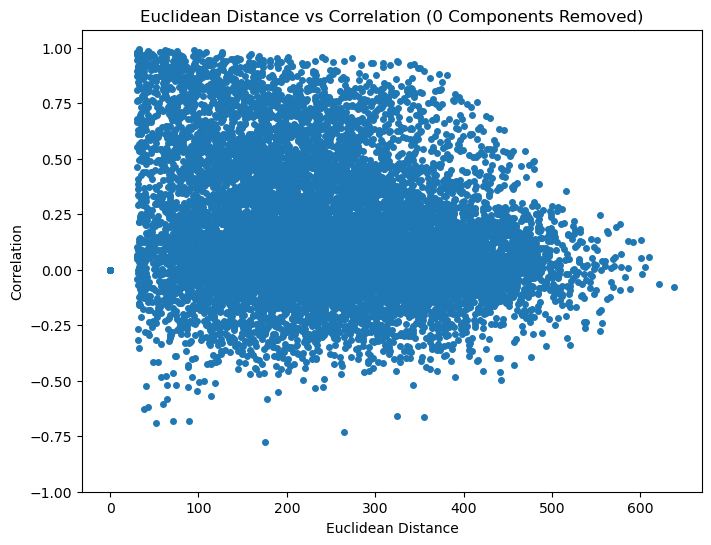

In [14]:
# Extract the upper triangle of the matrices
euclidean_distances_upper = np.triu(distance_matrix, k = 1).flatten()
correlation_matrix_upper = np.triu(correlation_matrix, k = 1).flatten()
correlation_matrix_reconst_upper = np.triu(correlation_matrix_reconst, k = 1).flatten()

# Plot the scatter plot (pca altered correlation matrix)
plt.figure(figsize = (8, 6))
plt.plot(euclidean_distances_upper, correlation_matrix_reconst_upper, marker = "o", linestyle = "None", markersize = 4)
plt.ylim(-1)
if count == 1:
    plt.title(f"Euclidean Distance vs Correlation ({count} Component Removed)")
else:
    plt.title(f"Euclidean Distance vs Correlation ({count} Components Removed)")
plt.xlabel("Euclidean Distance")
plt.ylabel("Correlation")
plt.show()

In [15]:
def correlation_finder(correlations, target_mean_degree, error, square_labels, square_coordinates):
    # Find correlation
    for correal in correlations:
        # Create a graph from the correlation matrix
        G = nx.Graph()
        num_squares = correlation_matrix_reconst.shape[0]
        G.add_nodes_from(range(0, num_squares))
    
        # Set correlation threshold
        correlation_threshold = correal
        corrrr = []
    
        # Add edges based on correlation threshold
        for i in range(num_squares):
            for j in range(i + 1, num_squares):
                correlation_value = correlation_matrix_reconst[i, j]
                if correlation_value >= correlation_threshold:
                    corrrr.append(correlation_value)
                    G.add_edge(i, j)
    
        isolated_nodes = [node for node in G.nodes() if G.degree[node] == 0]
        
        G_filtered = G.copy()
        G_filtered.remove_nodes_from(isolated_nodes)
    
        # Update square_labels based on nodes in G_filtered
        square_labels_filtered = {node: square_labels[node] for node in G_filtered.nodes()}
    
        # Get the largest connected component
        largest_component = max(nx.connected_components(G_filtered), key=len)
    
        # Create a subgraph with only the largest connected component
        G_largest = G_filtered.subgraph(largest_component)
    
        # Update square_labels based on nodes in G_largest
        square_labels_filtered = {node: square_labels[node] for node in G_largest.nodes()}
    
        degree_sequence = sorted((d for n, d in G_largest.degree()), reverse=True)
    
        # Calculate the mean degree (2 * num_links / num_nodes)
        mean_degree = sum(degree_sequence) / len(G_largest)
    
        # Calculate network density
        net_density = (len(G_largest.edges()) / math.comb(len(G_largest), 2))
        print(f"Correlation: {np.round(correal, 4)}, Mean: {mean_degree}, Nodes: {len(G_largest.nodes())}, Edges: {len(G_largest.edges())}")
        if target_mean - error <= mean_degree <= target_mean + error:
            print(f"Final correlation is: {np.round(correal, 4)}")
            return correal

In [16]:
# Hyperparameters for the 'correlation_finder()' function
square_labels = {i: f"{i + 1}" for i in range(0, 150)} # Square labels on network
square_coordinates = list(zip(x_vals, y_vals)) # Square coordinates from running 'calculate_and_draw_points()'
correlation_brute_force = [i for i in np.arange(0.0, 1.0, 0.001)] # List of correlations to try
target_mean = 15 # Target network mean degree
error = 0.1 # Margin of error for final network mean degree ([14.9, 15.1] for target_mean = 15 and error = 0.1)

In [17]:
# Find correlation
# Consider increasing the margin of error if you cannot find a correlation close to the target mean degree
correal = correlation_finder(correlations = correlation_brute_force, target_mean_degree = target_mean, error = error, square_labels = square_labels, square_coordinates = square_coordinates)

Correlation: 0.0, Mean: 106.21333333333334, Nodes: 150, Edges: 7966
Correlation: 0.001, Mean: 105.90666666666667, Nodes: 150, Edges: 7943
Correlation: 0.002, Mean: 105.6, Nodes: 150, Edges: 7920
Correlation: 0.003, Mean: 105.30666666666667, Nodes: 150, Edges: 7898
Correlation: 0.004, Mean: 105.06666666666666, Nodes: 150, Edges: 7880
Correlation: 0.005, Mean: 104.8, Nodes: 150, Edges: 7860
Correlation: 0.006, Mean: 104.54666666666667, Nodes: 150, Edges: 7841
Correlation: 0.007, Mean: 104.29333333333334, Nodes: 150, Edges: 7822
Correlation: 0.008, Mean: 104.13333333333334, Nodes: 150, Edges: 7810
Correlation: 0.009, Mean: 103.86666666666666, Nodes: 150, Edges: 7790
Correlation: 0.01, Mean: 103.6, Nodes: 150, Edges: 7770
Correlation: 0.011, Mean: 103.38666666666667, Nodes: 150, Edges: 7754
Correlation: 0.012, Mean: 103.14666666666666, Nodes: 150, Edges: 7736
Correlation: 0.013, Mean: 102.89333333333333, Nodes: 150, Edges: 7717
Correlation: 0.014, Mean: 102.78666666666666, Nodes: 150, Edge

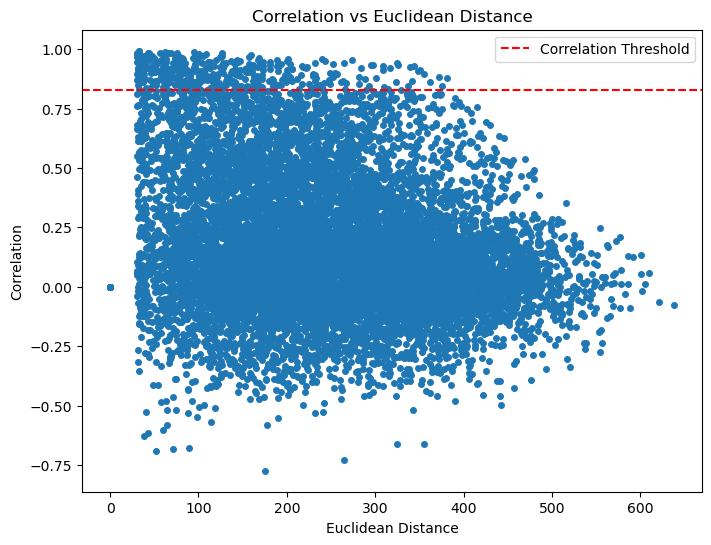

In [18]:
# Plot the scatter plot (PCA altered correlation matrix)
plt.figure(figsize = (8, 6))
plt.plot(euclidean_distances_upper, correlation_matrix_reconst_upper, marker = "o", linestyle = "None", markersize = 4)
plt.axhline(y = correal, linestyle = "--", color = "red", label = "Correlation Threshold")

if count == 1:
    plt.title(f"Correlation vs Euclidean Distance")
else:
    plt.title(f"Correlation vs Euclidean Distance")

plt.xlabel("Euclidean Distance")
plt.ylabel("Correlation")
plt.legend()
plt.savefig(f"{tif_file_name}_euclid_corr.pdf")
plt.show()

In [19]:
import scipy.special as special

def betai(a, b, x):
    x = np.asarray(x)
    x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0
    return special.betainc(a, b, x)

n = standscale.shape[0]
r = correal
r = max(min(r, 1.0), -1.0)
df = n - 2
if abs(r) == 1.0:
    prob = 0.0
else:
    t_squared = r * r * (df / ((1.0 - r) * (1.0 + r)))
    prob = betai(0.5 * df, 0.5, df / (df + t_squared))
print(f"Corr: {r}, p-value: {prob}")
print(f"Does p-value round to 1/10000? {np.round(prob, 5) == 1 / 10000}")
print(f"p-value < 0.05? {prob < 0.05}")

Corr: 0.8290000000000001, p-value: 2.250796354082188e-52
Does p-value round to 1/10000? False
p-value < 0.05? True


0.8290000000000001


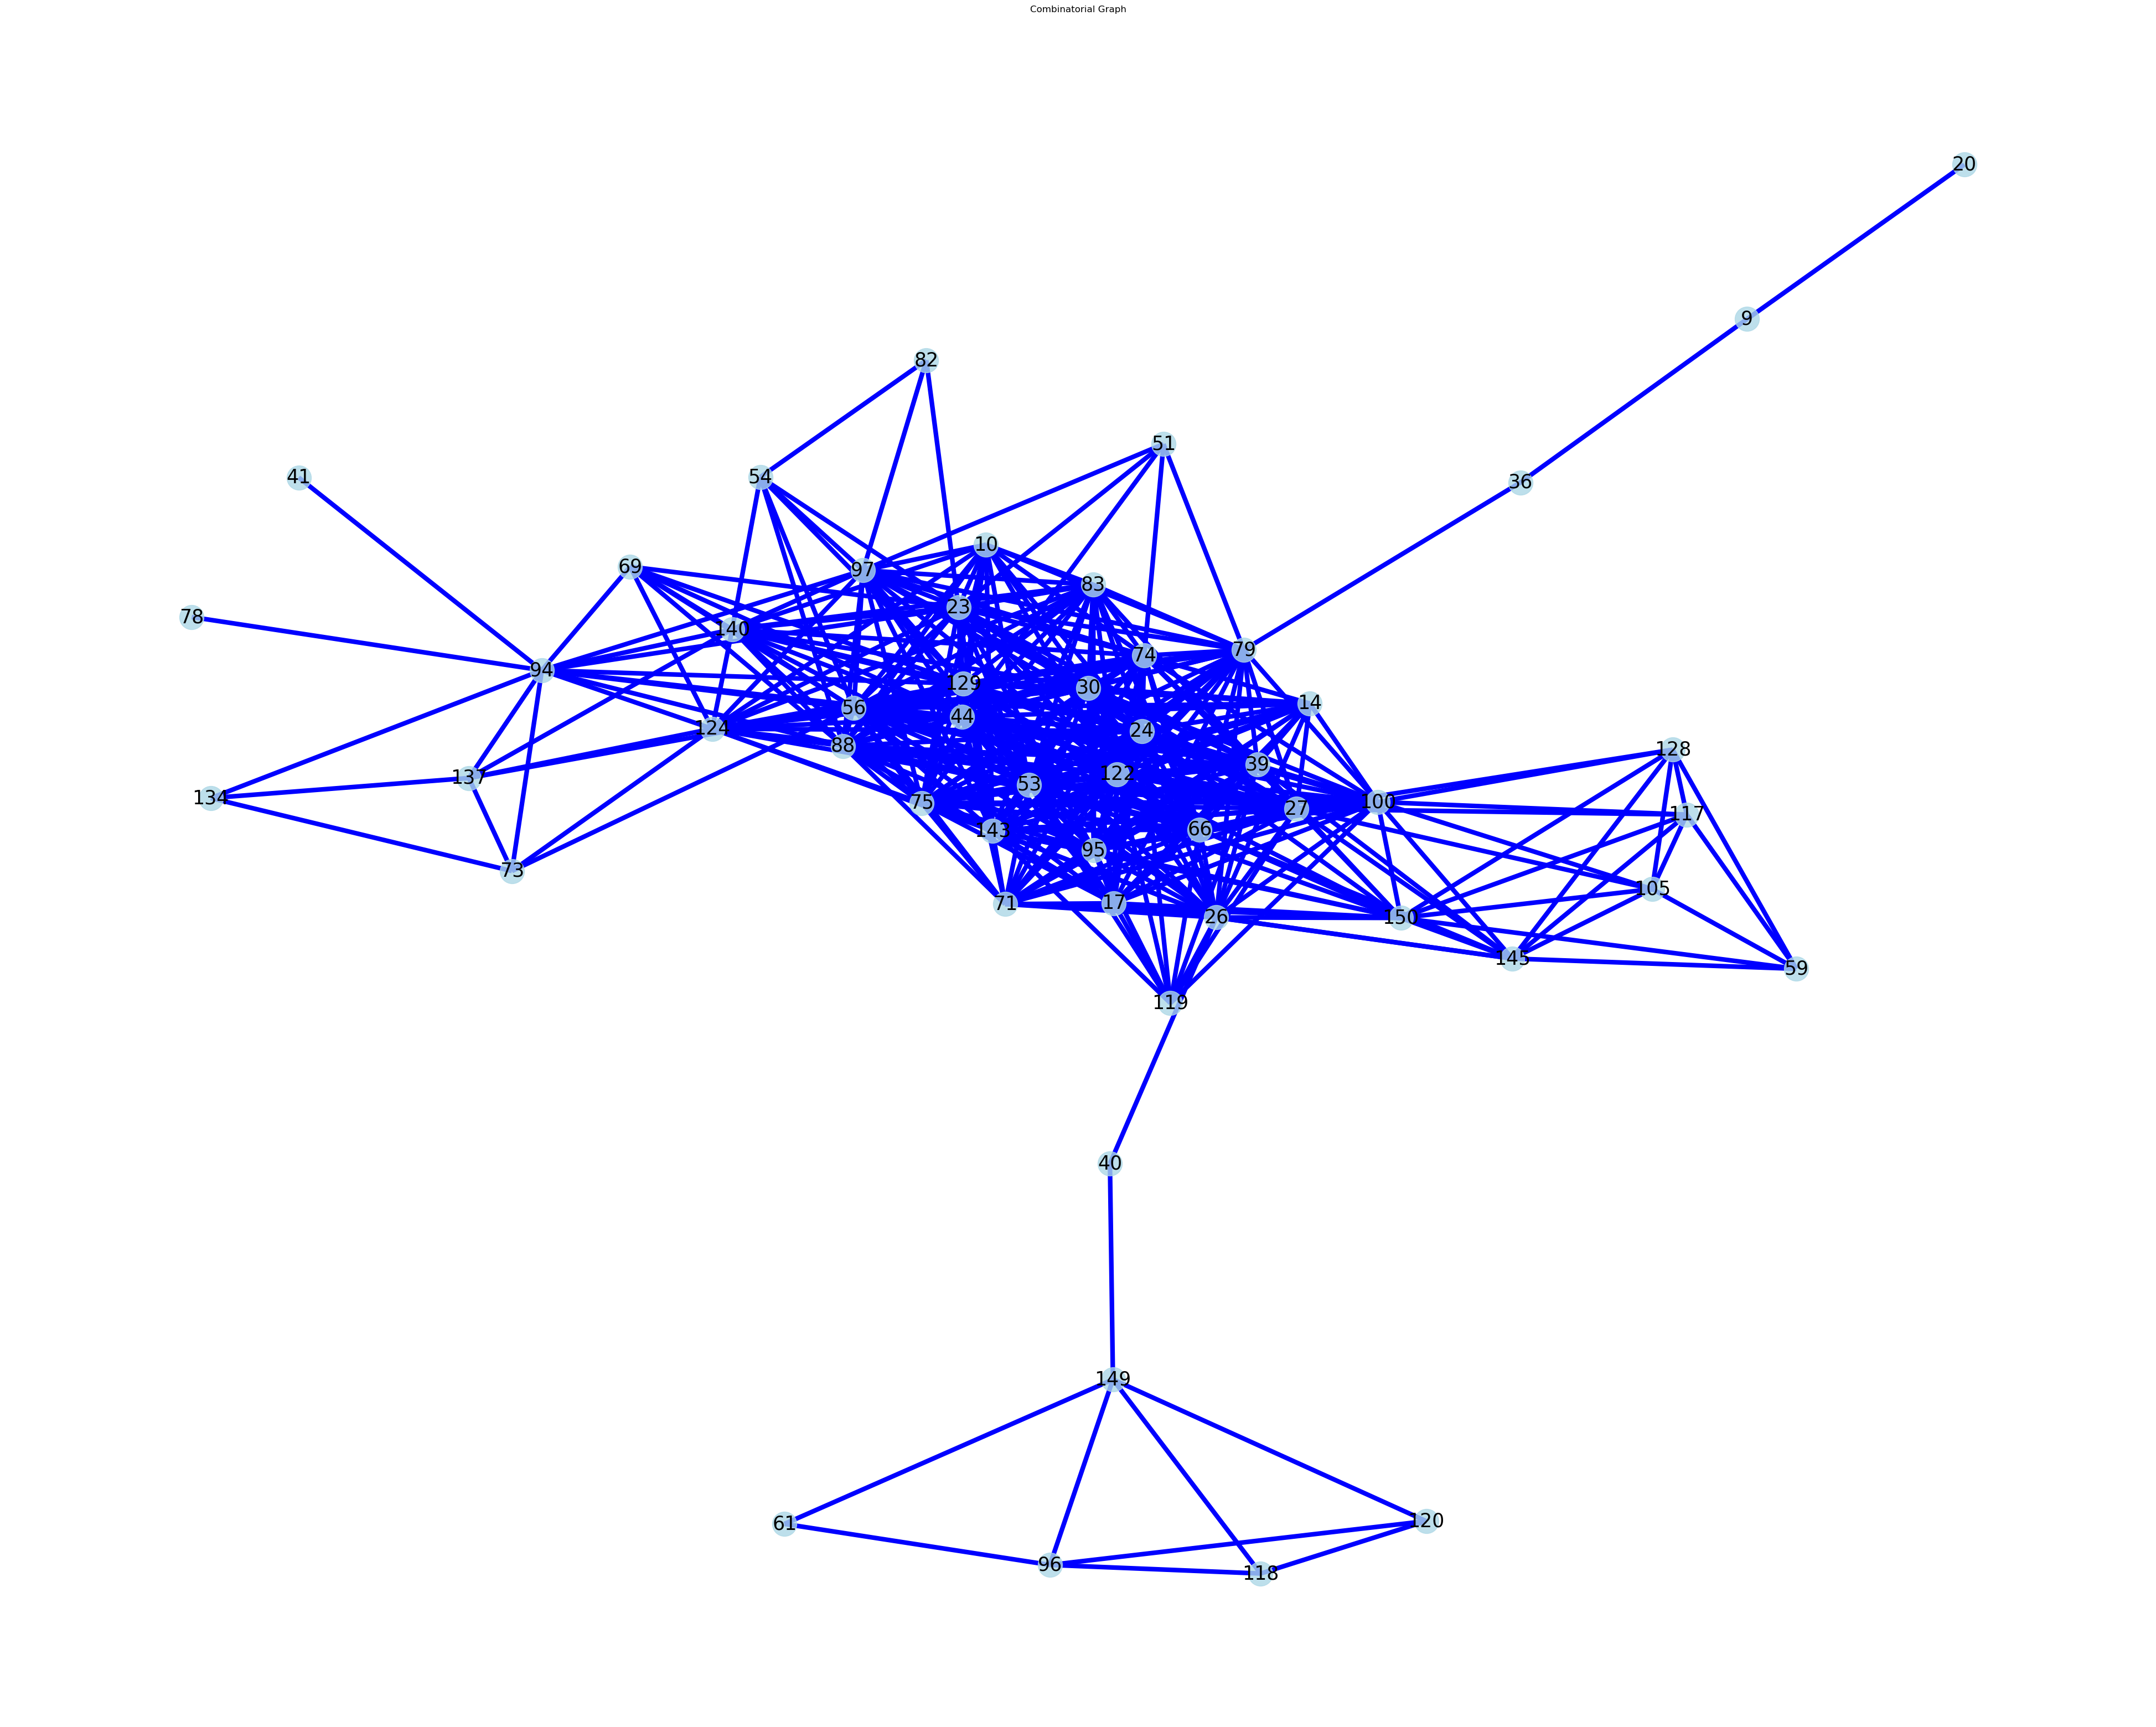

Degree Sequence: [29, 29, 29, 28, 28, 27, 27, 27, 27, 26, 26, 26, 26, 25, 25, 25, 24, 24, 23, 22, 21, 21, 20, 20, 18, 18, 17, 17, 14, 11, 11, 8, 7, 7, 7, 7, 6, 5, 5, 5, 5, 4, 3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1]


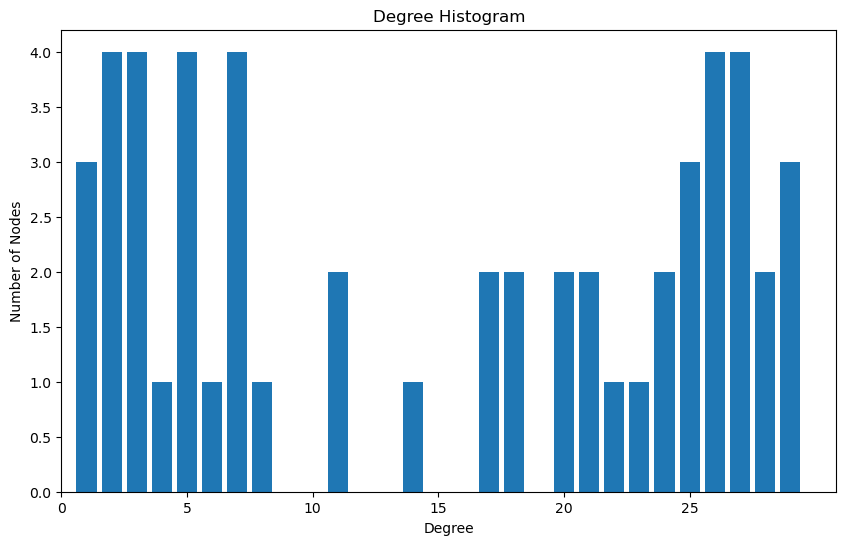

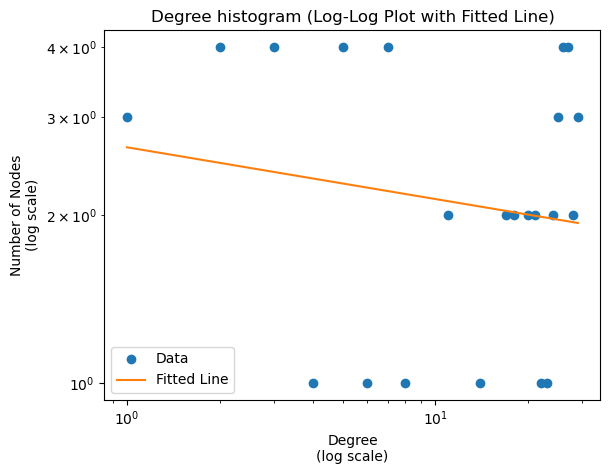

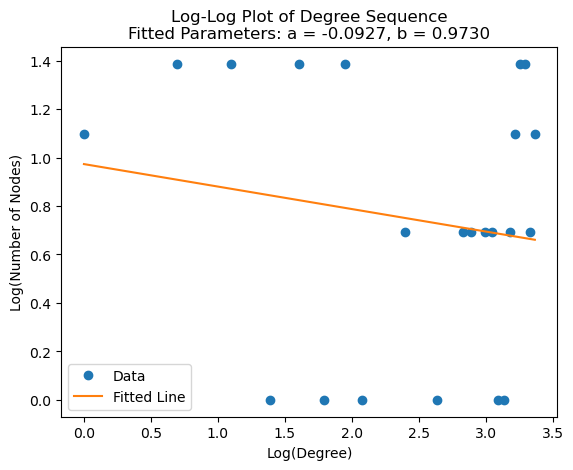

R-squared value: 0.0272
R-squared value: 0.0272
Kurtosis of the histogram (fisher = False): 1.6741490138787434
[3 4 4 1 4 1 4 1 2 1 2 2 2 2 1 1 2 3 4 4 5]
[0, 3, 4, 4, 1, 4, 1, 4, 1, 0, 0, 2, 0, 0, 1, 0, 0, 2, 2, 0, 2, 2, 1, 1, 2, 3, 4, 4, 2, 3]
Number of squares: 53
Graph with 53 nodes and 400 edges


In [20]:
# Create a graph from the correlation matrix
G = nx.Graph()
num_squares = correlation_matrix.shape[0]
G.add_nodes_from(range(0, num_squares))

# Set correlation threshold
print(r)
correlation_threshold = r
corrrr = []

# Add edges based on correlation threshold
for i in range(num_squares):
    for j in range(i + 1, num_squares):
        correlation_value = correlation_matrix_reconst[i, j]
        if correlation_value >= correlation_threshold:
            corrrr.append(correlation_value)
            G.add_edge(i, j)

isolated_nodes = [node for node in G.nodes() if G.degree[node] == 0]
G_filtered = G.copy()
G_filtered.remove_nodes_from(isolated_nodes)

# Update square_labels based on nodes in G_filtered
square_labels_filtered = {node: square_labels[node] for node in G_filtered.nodes()}

# Get the largest connected component
largest_component = max(nx.connected_components(G_filtered), key = len)

# Create a subgraph with only the largest connected component
G_largest = G_filtered.subgraph(largest_component)

net_density = (len(G_largest.edges()) / math.comb(len(G_largest), 2))

# Update square_labels based on nodes in G_largest
square_labels_filtered = {node: square_labels[node] for node in G_largest.nodes()}

plt.figure(figsize = (50, 40))
pos = nx.kamada_kawai_layout(G_largest)

nx.draw_networkx_edges(G_largest, pos, edgelist=G_largest.edges, width = 6, edge_color = "blue")

nx.draw_networkx_nodes(G_largest, pos, node_color = "lightblue", node_size = 1000, alpha = 0.8)
nx.draw_networkx_labels(G_largest, pos, labels = square_labels_filtered, font_size = 25)
plt.title("Combinatorial Graph")
plt.axis("off")
plt.show()

degree_sequence = sorted((d for n, d in G_largest.degree()), reverse = True)
dmax = max(degree_sequence)

print(f"Degree Sequence: {degree_sequence}")

degrees, counts = np.unique(degree_sequence, return_counts = True)

plt.figure(figsize = (10, 6))
plt.bar(degrees, counts)
plt.title("Degree Histogram")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.xticks(range(0, max(degree_sequence) + 1, 5))
plt.xlim(0)
plt.savefig(f"degree_hist{tif_file_name}.pdf")
plt.show()

log_degrees = np.log(degrees)
log_counts = np.log(counts)
coefficients = np.polyfit(log_degrees, log_counts, 1)
fit_line = np.poly1d(coefficients)

plt.loglog(degrees, counts, "o", label = "Data")
plt.loglog(degrees, np.exp(1) ** fit_line(log_degrees), "-", label = "Fitted Line")
plt.title("Degree histogram (Log-Log Plot with Fitted Line)")
plt.xlabel("Degree\n(log scale)")
plt.ylabel("Number of Nodes\n(log scale)")
plt.legend()
plt.show()

# Define the function to fit a line in ln-ln space
def linear_fit(x, a, b):
    return a * x + b

# Convert data to ln-ln space
ln_degrees = np.log(degrees)
ln_counts = np.log(counts)

# Fit the line
popt, _ = curve_fit(linear_fit, ln_degrees, ln_counts)

# Summarise the parameter values
a, b = popt

# Create a range of x-values for the fitted line
x_fit = np.linspace(min(ln_degrees), max(ln_degrees), 100)

# Calculate the corresponding y-values for the fitted line
y_fit = linear_fit(x_fit, a, b)

# Plot the data and the fitted line in ln-ln space
plt.plot(ln_degrees, ln_counts, "o", label = "Data")
plt.plot(x_fit, y_fit, label = "Fitted Line")
plt.xlabel("Log(Degree)")
plt.ylabel("Log(Number of Nodes)")
plt.title(f"Log-Log Plot of Degree Sequence\nFitted Parameters: a = {a:.4f}, b = {b:.4f}")
plt.legend()
plt.savefig(f"{tif_file_name}_log_degree.pdf")
plt.show()

# Calculate the R-squared value
r2_value = r2_score(log_counts, fit_line(log_degrees))

# Print the R-squared value
print(f"R-squared value: {r2_value:.4f}")

# Calculate the R-squared value
r2_value = r2_score(ln_counts, fit_line(ln_degrees))

# Print the R-squared value
print(f"R-squared value: {r2_value:.4f}")

# Create a histogram of the data
hist, bin_edges = np.histogram(degrees, bins = degrees, weights = counts)

# Calculate the kurtosis of the histogram
hist_kurtosis_degree = stats.kurtosis(hist, bias = True, fisher = False)

# Print the kurtosis value
print("Kurtosis of the histogram (fisher = False):", hist_kurtosis_degree)
print(hist)

print(nx.degree_histogram(G_largest))

print(f"Number of squares: {len(G_largest)}")
print(G_largest)

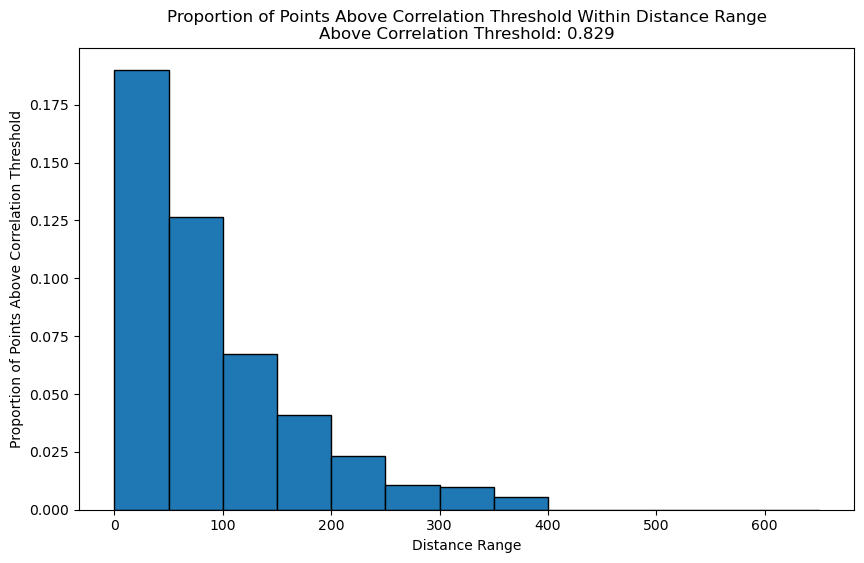

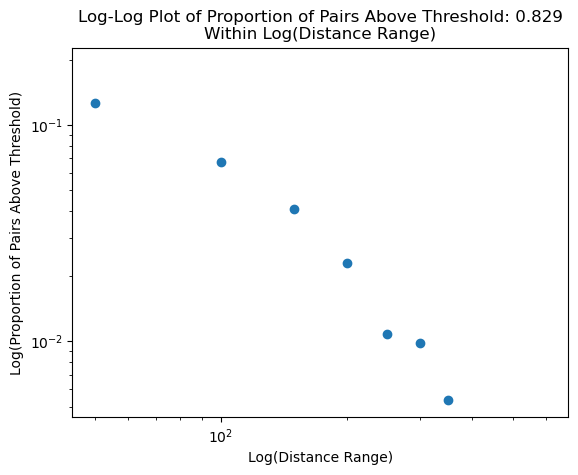

C:\Users\barla\AppData\Local\Temp\ipykernel_13220\2799484894.py:58: RuntimeWarning: divide by zero encountered in log
  ln_proportions = np.log(proportions[1:-1])


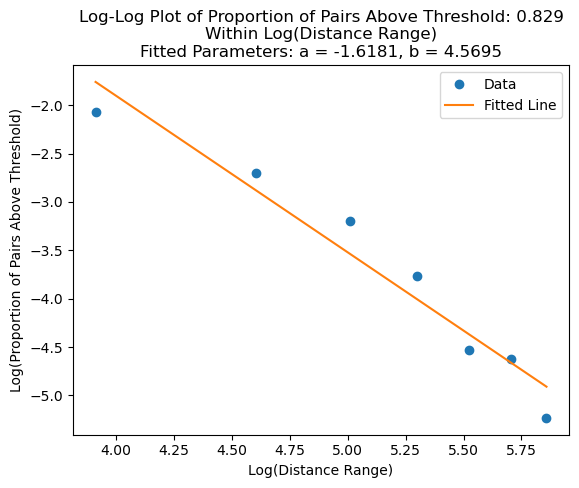

Fitted Parameters: a = -1.6181, b = 4.5695
Kurtosis of the histogram (fisher = False): 4.719426127629969
11175
[ 305  926 1337 1569 1644 1574 1426 1123  757  356  120   31    7]
404
[ 58 117  90  64  38  17  14   6   0   0   0   0   0]
[0.19016393 0.12634989 0.06731488 0.04079031 0.02311436 0.01080051
 0.00981767 0.00534283 0.         0.         0.         0.
 0.        ]


13

In [21]:
distance_bins = [i for i in np.arange(0, np.max(distance_matrix) + 50, 50)]

# Initialise an array to store the counts of points within each distance range
distance_counts = np.zeros(len(distance_bins) - 1, dtype = int)

# Initialise an array to store the counts of points above the correlation threshold within each bin
above_threshold_counts = np.zeros(len(distance_bins) - 1, dtype = int)

# Specify the correlation threshold
correlation_threshold = r

# Iterate through each pair of points
num_points = len(distance_matrix)
for i in range(num_points):
    for j in range(i + 1, num_points):
        distance = distance_matrix[i, j]
        correlation = correlation_matrix_reconst[i, j]

        # Count points within distance bins
        for bin_index, bin_end in enumerate(distance_bins[1:]):
            if distance <= bin_end:
                distance_counts[bin_index] += 1
                # Check if correlation is above the threshold for the current pair
                if correlation >= correlation_threshold:
                    above_threshold_counts[bin_index] += 1
                break

proportions = above_threshold_counts/distance_counts

# Create the stacked histogram
plt.figure(figsize = (10, 6))
plt.hist(
    [distance_bins[:-1]],
    bins = distance_bins,
    weights = [proportions],
    stacked = False,
    edgecolor = "black",
)

plt.xlabel("Distance Range")
plt.ylabel("Proportion of Points Above Correlation Threshold")
plt.title(f"Proportion of Points Above Correlation Threshold Within Distance Range\nAbove Correlation Threshold: {correlation_threshold:.3f}")
plt.xticks([i for i in np.arange(0, np.max(distance_matrix) + 50, 100)])
plt.show()

plt.loglog(distance_bins[:-1], proportions, "o", label = "Data")
plt.xlabel("Log(Distance Range)")
plt.ylabel("Log(Proportion of Pairs Above Threshold)")
plt.title(f"Log-Log Plot of Proportion of Pairs Above Threshold: {correlation_threshold:.3f}\nWithin Log(Distance Range)")
plt.show()

# Define the function to fit a line in ln-ln space
def linear_fit(x, a, b):
    return a * x + b

# Convert data to ln-ln space
ln_distance_bins = np.log(distance_bins[1:-2])
ln_proportions = np.log(proportions[1:-1])

# Check for NaN and inf values in log_proportions
invalid_values = np.isnan(ln_proportions) | np.isinf(ln_proportions)

# Filter out invalid values from both x and y arrays
ln_distance_bins = ln_distance_bins[~invalid_values]
ln_proportions = ln_proportions[~invalid_values]

# Fit the line
popt, _ = curve_fit(linear_fit, ln_distance_bins, ln_proportions)

# Summarise the parameter values
a, b = popt

# Create a range of x-values for the fitted line
x_fit = np.linspace(min(ln_distance_bins), max(ln_distance_bins), 100)

# Calculate the corresponding y-values for the fitted line
y_fit = linear_fit(x_fit, a, b)

# Plot the data and the fitted line in ln-ln space
plt.plot(ln_distance_bins, ln_proportions, "o", label = "Data")
plt.plot(x_fit, y_fit, label = "Fitted Line")
plt.xlabel("Log(Distance Range)")
plt.ylabel("Log(Proportion of Pairs Above Threshold)")
plt.title(f"Log-Log Plot of Proportion of Pairs Above Threshold: {correlation_threshold:.3f}\nWithin Log(Distance Range)\nFitted Parameters: a = {a:.4f}, b = {b:.4f}")
plt.legend()
plt.show()

# Print the fitted parameters (a and b)
print(f"Fitted Parameters: a = {a:.4f}, b = {b:.4f}")

# Create a histogram of the data
hist, bin_edges = np.histogram(distance_bins[:-1], bins = distance_bins, weights = proportions)

# Calculate the kurtosis of the histogram
hist_kurtosis_proportion = stats.kurtosis(hist, bias = True, fisher = False)

# Print the kurtosis value
print("Kurtosis of the histogram (fisher = False):", hist_kurtosis_proportion)

print(sum(distance_counts))
print(distance_counts)
print(sum(above_threshold_counts))
print(above_threshold_counts)
print(proportions)
len(above_threshold_counts)

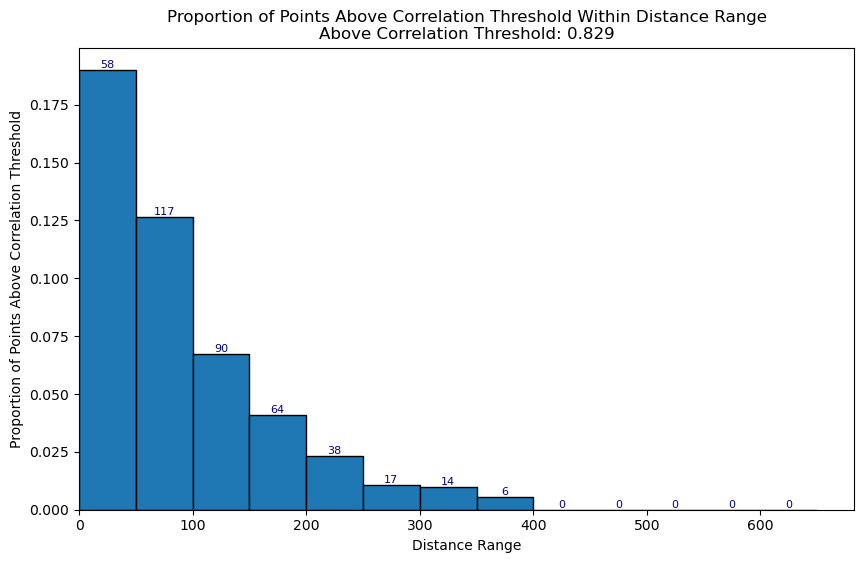

[ 305  926 1337 1569 1644 1574 1426 1123  757  356  120   31    7]
[ 58 117  90  64  38  17  14   6   0   0   0   0   0]
[0.19016393 0.12634989 0.06731488 0.04079031 0.02311436 0.01080051
 0.00981767 0.00534283 0.         0.         0.         0.
 0.        ]


In [22]:
plt.figure(figsize = (10, 6))

values, bins, bars = plt.hist([distance_bins[:-1]], bins = distance_bins, weights = [proportions], stacked = False, edgecolor = "black", color = "tab:blue")

# Set custom labels for the bars
plt.bar_label(bars, labels = above_threshold_counts, fontsize=8, color = "navy")
plt.xlabel("Distance Range")
plt.ylabel("Proportion of Points Above Correlation Threshold")
plt.title(f"Proportion of Points Above Correlation Threshold Within Distance Range\nAbove Correlation Threshold: {correlation_threshold:.3f}")
plt.xlim(0)
plt.xticks([i for i in np.arange(0, np.max(distance_matrix) + 50, 100)])
plt.savefig(f"prop_hist{tif_file_name}_num.pdf")
plt.show()

print(distance_counts)
print(above_threshold_counts)

print(above_threshold_counts / distance_counts)

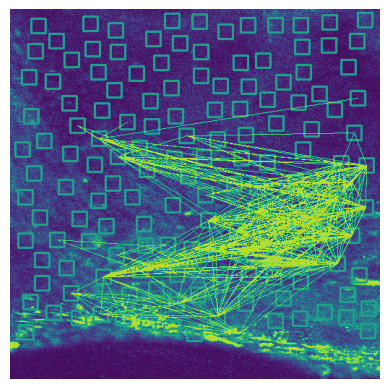

Graph with 53 nodes and 400 edges


In [23]:
# Euclidean Distance and Correlation Filtering (0, r respectively)

# Draw the graph on top of the video frames for the largest subgraph
for result in results:
    frame_num = result["frame"]
    frame = result["drawn_frame"]

    # Draw the graph edges for the largest subgraph
    for edge in G_largest.edges():
        square1 = edge[0]
        square2 = edge[1]
        x1, y1 = result["points"][0][square1], result["points"][1][square1]
        x2, y2 = result["points"][0][square2], result["points"][1][square2]
        cv2.line(frame, (y1, x1), (y2, x2), (255, 255, 255), 1)

# Display the last frame for the largest subgraph
plt.imshow(frame)
plt.axis("off")
plt.savefig(f"network_overlay_{tif_file_name}.pdf")
plt.show()
print(G_largest)

In [24]:
width, height = result["drawn_frame"].shape[1], result["drawn_frame"].shape[0]

# Create a folder to store the frames
output_folder = f"{tif_file_name}_images_network_overlay"
os.makedirs(output_folder, exist_ok = True)

# Set the JPEG quality (0-100, higher is better)
jpeg_quality = 100

for idx, result in enumerate(results):
    frame = result["drawn_frame"]

    # Draw the graph edges for the largest subgraph
    for edge in G_largest.edges():
        square1 = edge[0]
        square2 = edge[1]
        x1, y1 = result["points"][0][square1], result["points"][1][square1]
        x2, y2 = result["points"][0][square2], result["points"][1][square2]
        cv2.line(frame, (y1, x1), (y2, x2), (255, 255, 255), 1)

    # Save each frame as a higher-quality JPEG image in the output folder
    frame_filename = os.path.join(output_folder, f"frame_{idx:04d}.jpg")
    cv2.imwrite(frame_filename, frame, [int(cv2.IMWRITE_JPEG_QUALITY), jpeg_quality])

print(f"Frames saved to {output_folder}")
print(G_largest)

Frames saved to 1894_s5_corrected.tif_images_network_overlay
Graph with 53 nodes and 400 edges


In [25]:
cor_awa = []
# Iterate over the edges of the largest subgraph
for edge in G_filtered.edges:
    i, j = edge  # Get the nodes connected by the edge
    correlation_value = correlation_matrix_reconst[i, j]  # Get the correlation value
    cor_awa.append(correlation_value)
print(len(cor_awa))
print("old with corrrr:", np.mean(corrrr))
print(f"Average Correlation Value of Whole Network: {np.mean(cor_awa)}")

# Create an empty list to store correlations within the largest subgraph
correlations_in_largest_subgraph = []

# Iterate over the edges of the largest subgraph
for edge in G_largest.edges:
    i, j = edge # Get the nodes connected by the edge
    correlation_value = correlation_matrix_reconst[i, j] # Get the correlation value
    correlations_in_largest_subgraph.append(correlation_value)

# Calculate the mean correlation
mean_correlation_largest_subgraph = np.mean(correlations_in_largest_subgraph)

# Print the mean correlation
print(len(correlations_in_largest_subgraph))
print(f"Mean correlation in the largest subgraph: {mean_correlation_largest_subgraph}")

# Calculate the clustering coefficient for each node
clustering_coefficients = nx.clustering(G_largest)

# Calculate the average clustering coefficient
average_clustering_coefficient = sum(clustering_coefficients.values()) / len(G_largest)

# Calculate the global efficiency
global_efficiency = nx.global_efficiency(G_largest)

# Calculate the local efficiency
local_efficiency = nx.local_efficiency(G_largest)

# Calculate the mean degree (2 * num_links / num_nodes)
mean_degree = sum(degree_sequence) / len(G_largest)

# Calculate the standard deviation of the degrees
standard_degree = np.std(degree_sequence)

# Get a list of all connected components
connected_components = list(nx.connected_components(G_filtered))

# Calculate average shortest path length for each connected component
average_shortest_path_lengths = [nx.average_shortest_path_length(G_filtered.subgraph(component)) for component in connected_components]

# Largest subgraph average shortest path length
average_shortest = nx.average_shortest_path_length(G_largest)

print("\nClustering Coefficients:", clustering_coefficients)
print("\nAverage Clustering Coefficient:", average_clustering_coefficient)
print("\nAverage Global Efficiency:", global_efficiency)
print("\nAverage Local Efficiency:", local_efficiency)
print("\nMean Degree:", mean_degree, "\n")
if len(average_shortest_path_lengths) > 1:
    print("Graph is not connected, taking average shortest path length of largest subgraph:")
print("Average Shortest Path Length:", average_shortest)
print("\nMinimum Degree:", min(degrees))
print("\nMaximum Degree:", max(degrees))

404
old with corrrr: 0.9018202684144804
Average Correlation Value of Whole Network: 0.9018202684144804
400
Mean correlation in the largest subgraph: 0.9024072886247129

Clustering Coefficients: {8: 0, 9: 0.9705882352941176, 13: 0.9869281045751634, 16: 0.83399209486166, 19: 0, 22: 0.6584615384615384, 23: 0.7645502645502645, 25: 0.7748917748917749, 26: 0.6780626780626781, 29: 0.8246153846153846, 35: 0, 38: 0.8033333333333333, 39: 0, 40: 0, 43: 0.7044334975369458, 50: 1.0, 52: 0.7645502645502645, 53: 0.8095238095238095, 55: 0.6403940886699507, 58: 1.0, 60: 1.0, 65: 0.8033333333333333, 68: 1.0, 70: 0.9285714285714286, 72: 0.8, 73: 0.7749287749287749, 74: 0.8246153846153846, 77: 0, 78: 0.76, 81: 1.0, 82: 0.9157894736842105, 87: 0.7353846153846154, 93: 0.4725274725274725, 94: 0.8514492753623188, 95: 0.6666666666666666, 96: 0.7142857142857143, 99: 0.6920289855072463, 104: 0.9047619047619048, 116: 0.9047619047619048, 117: 1.0, 118: 1.0, 119: 1.0, 121: 0.7863247863247863, 123: 0.726315789473684

3


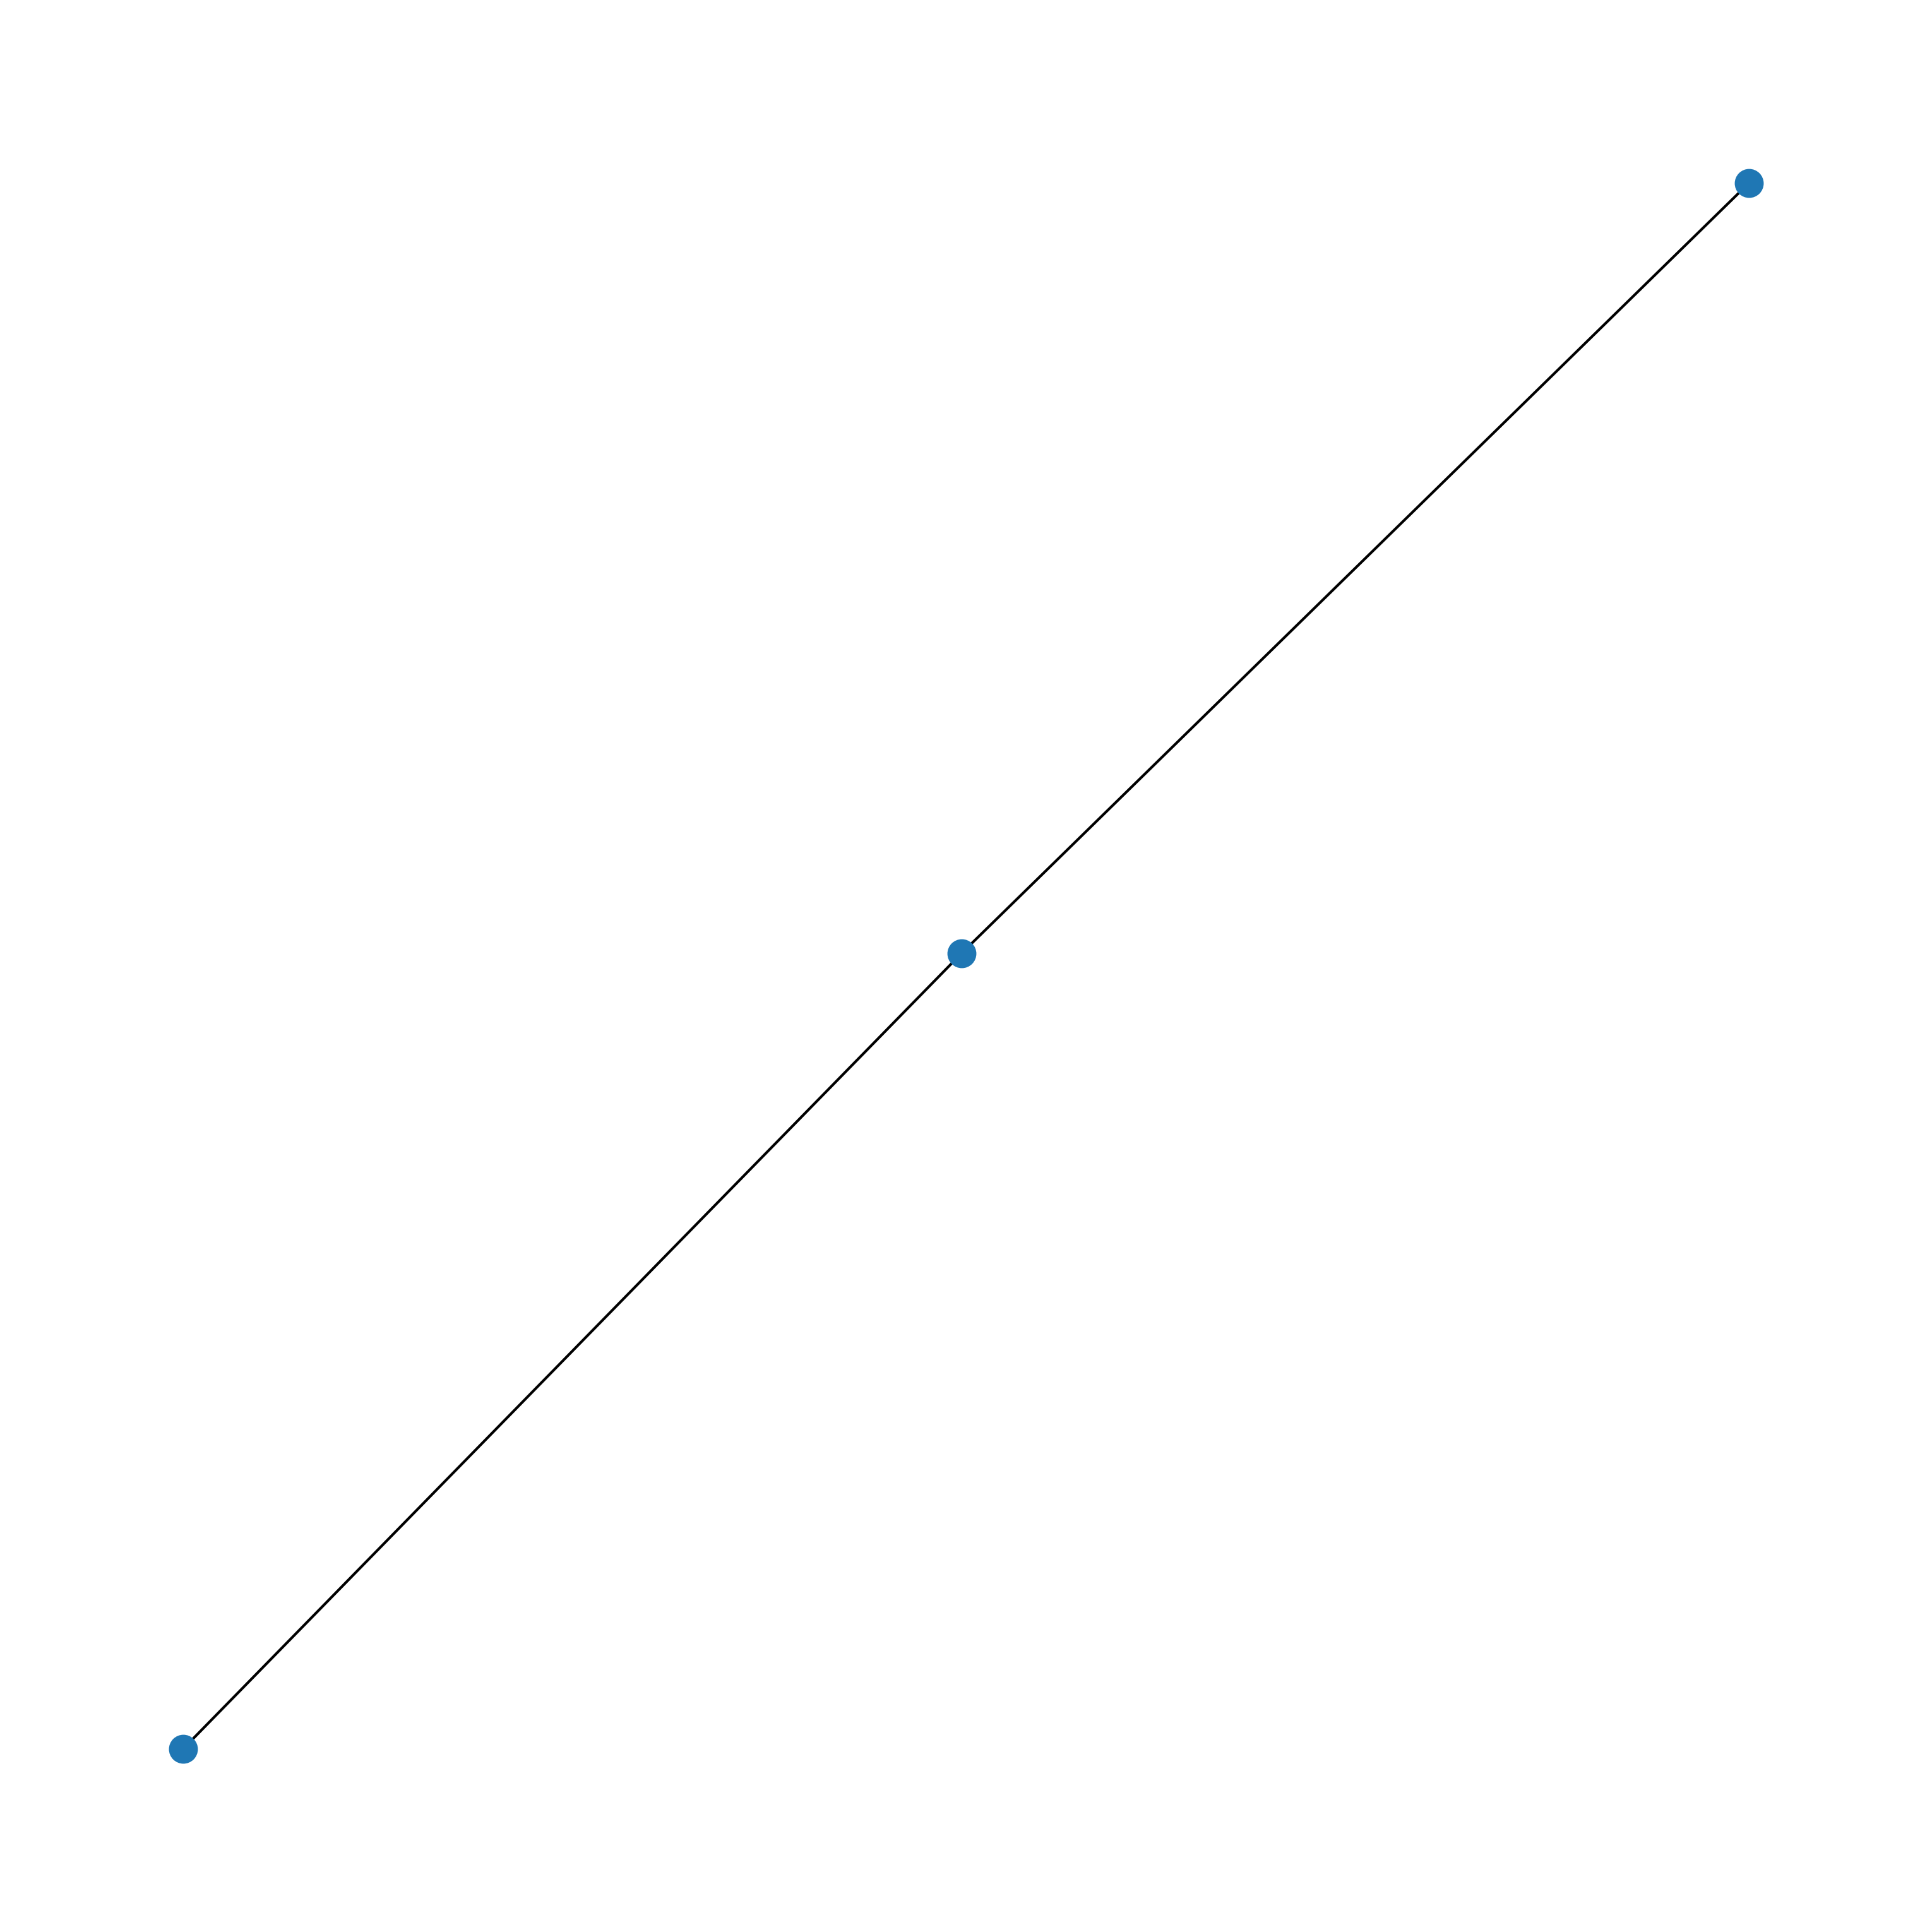

53


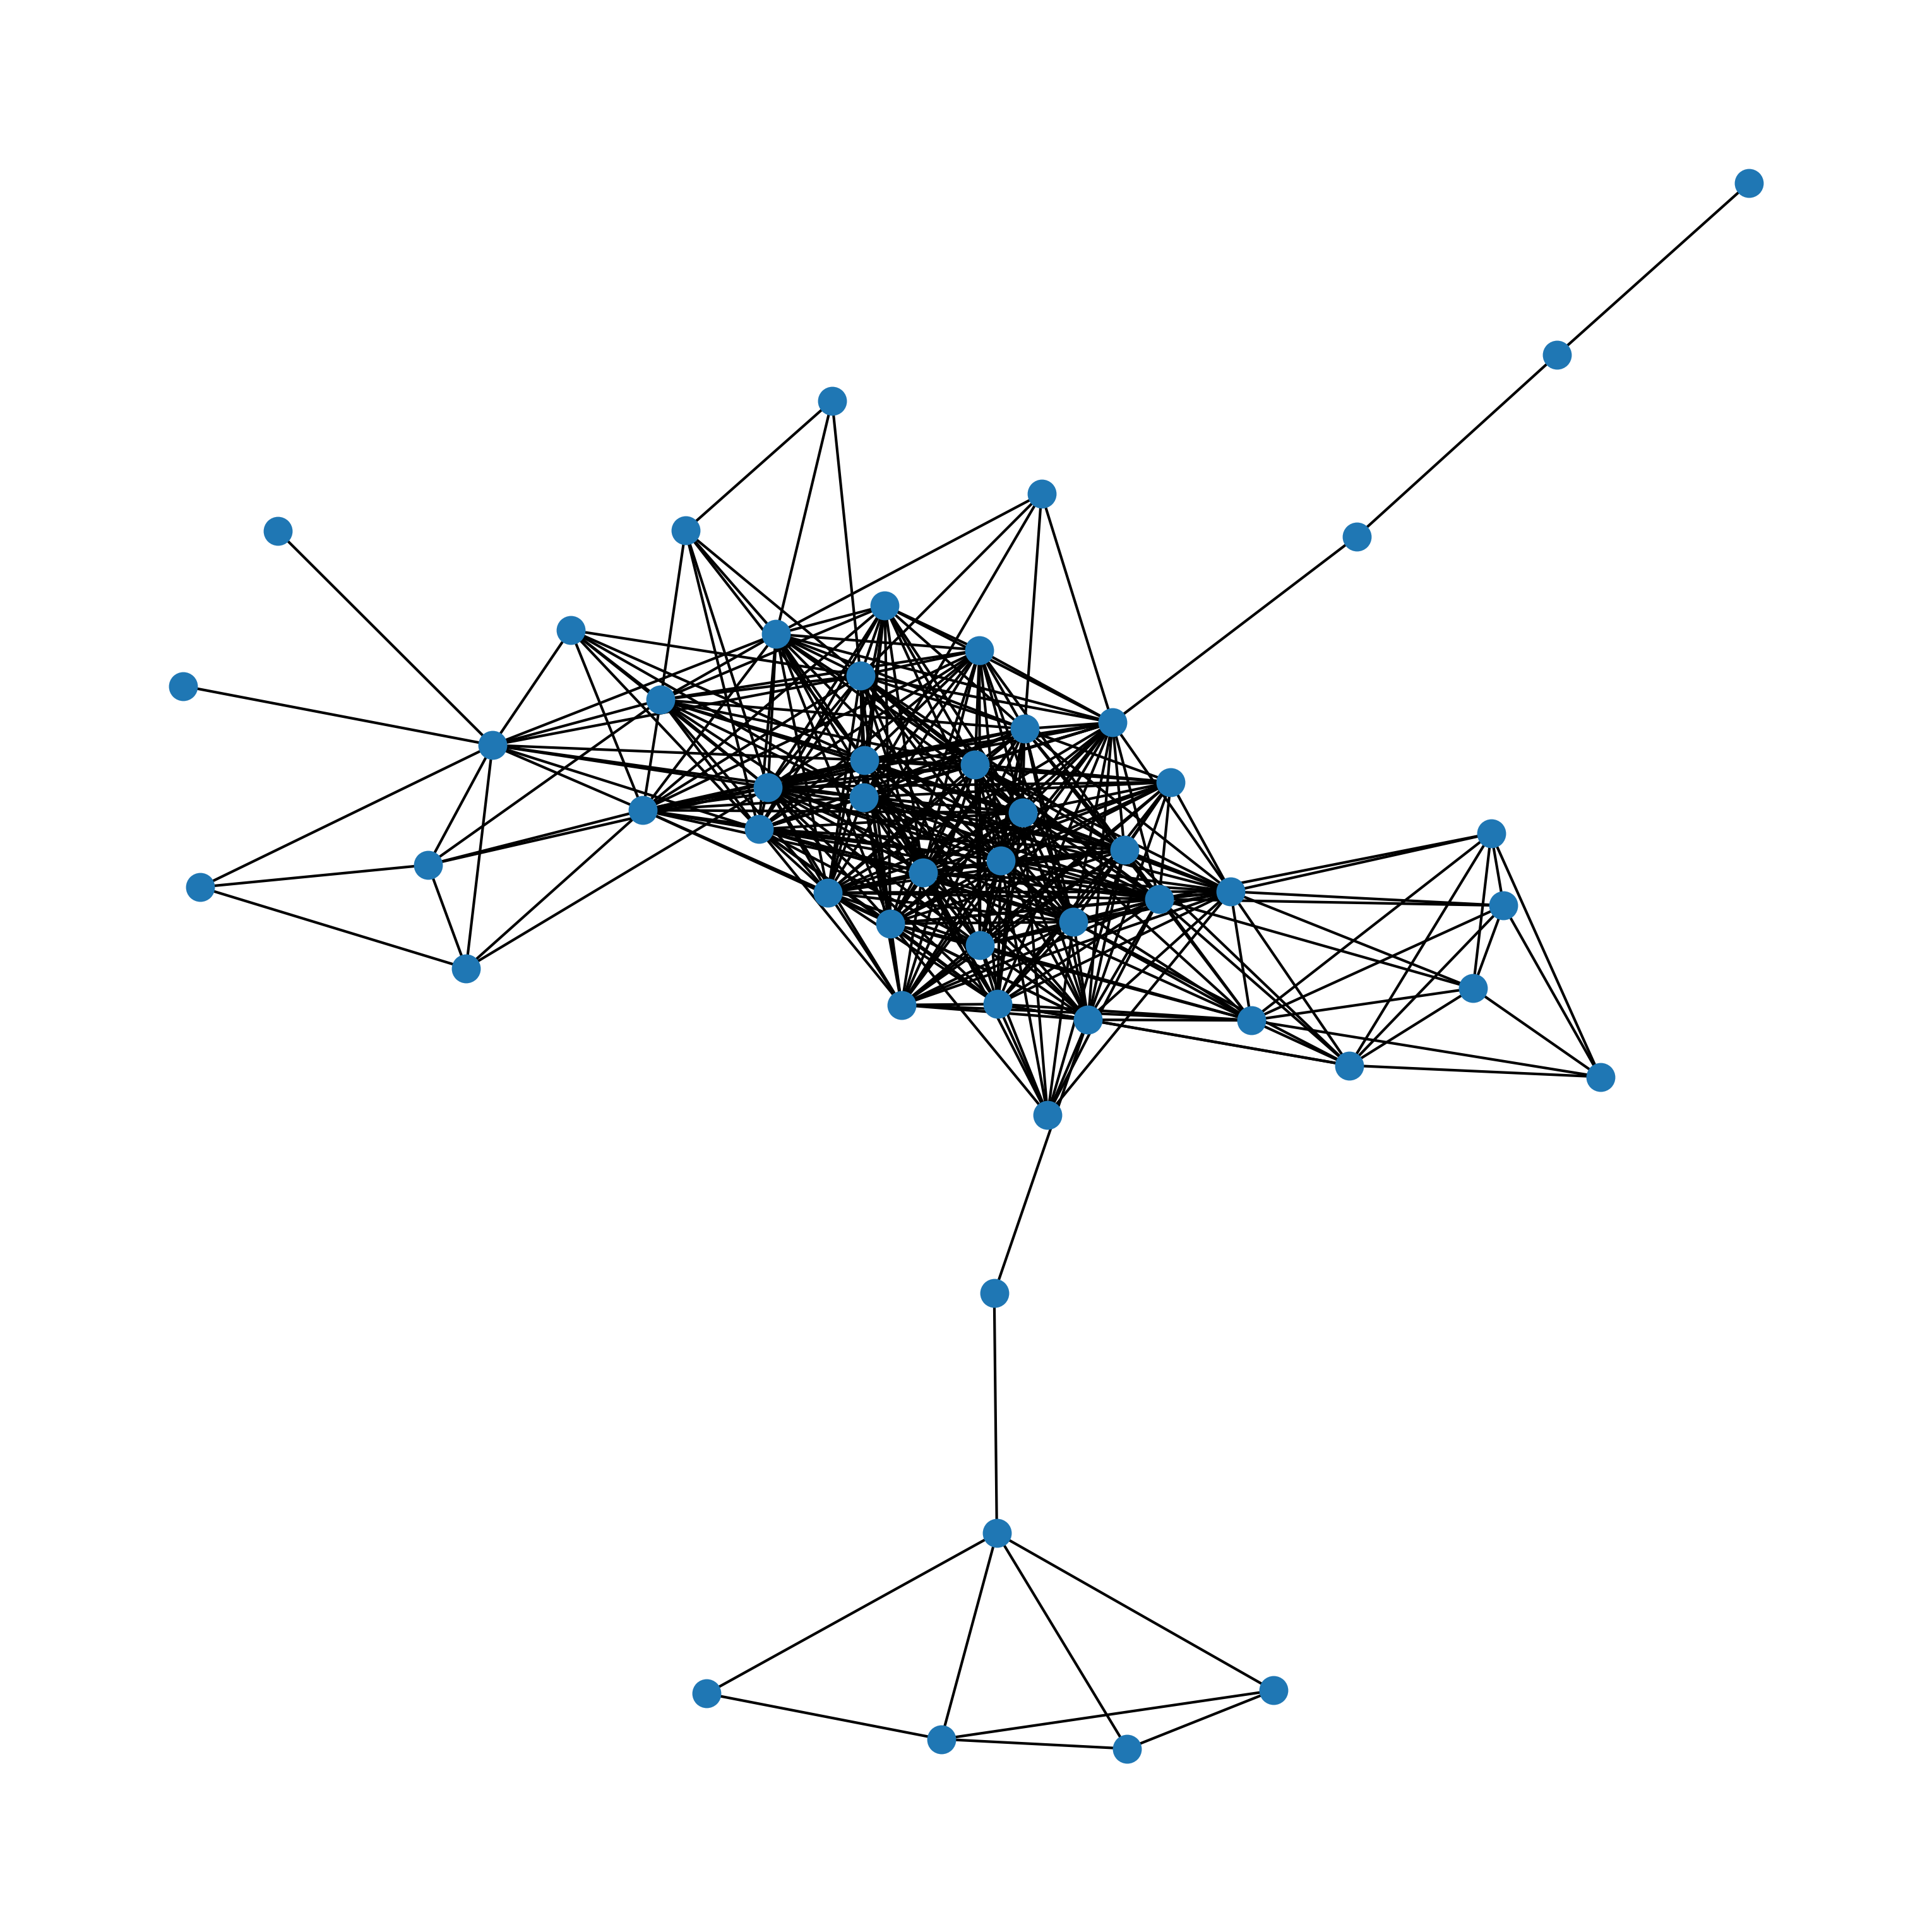

2


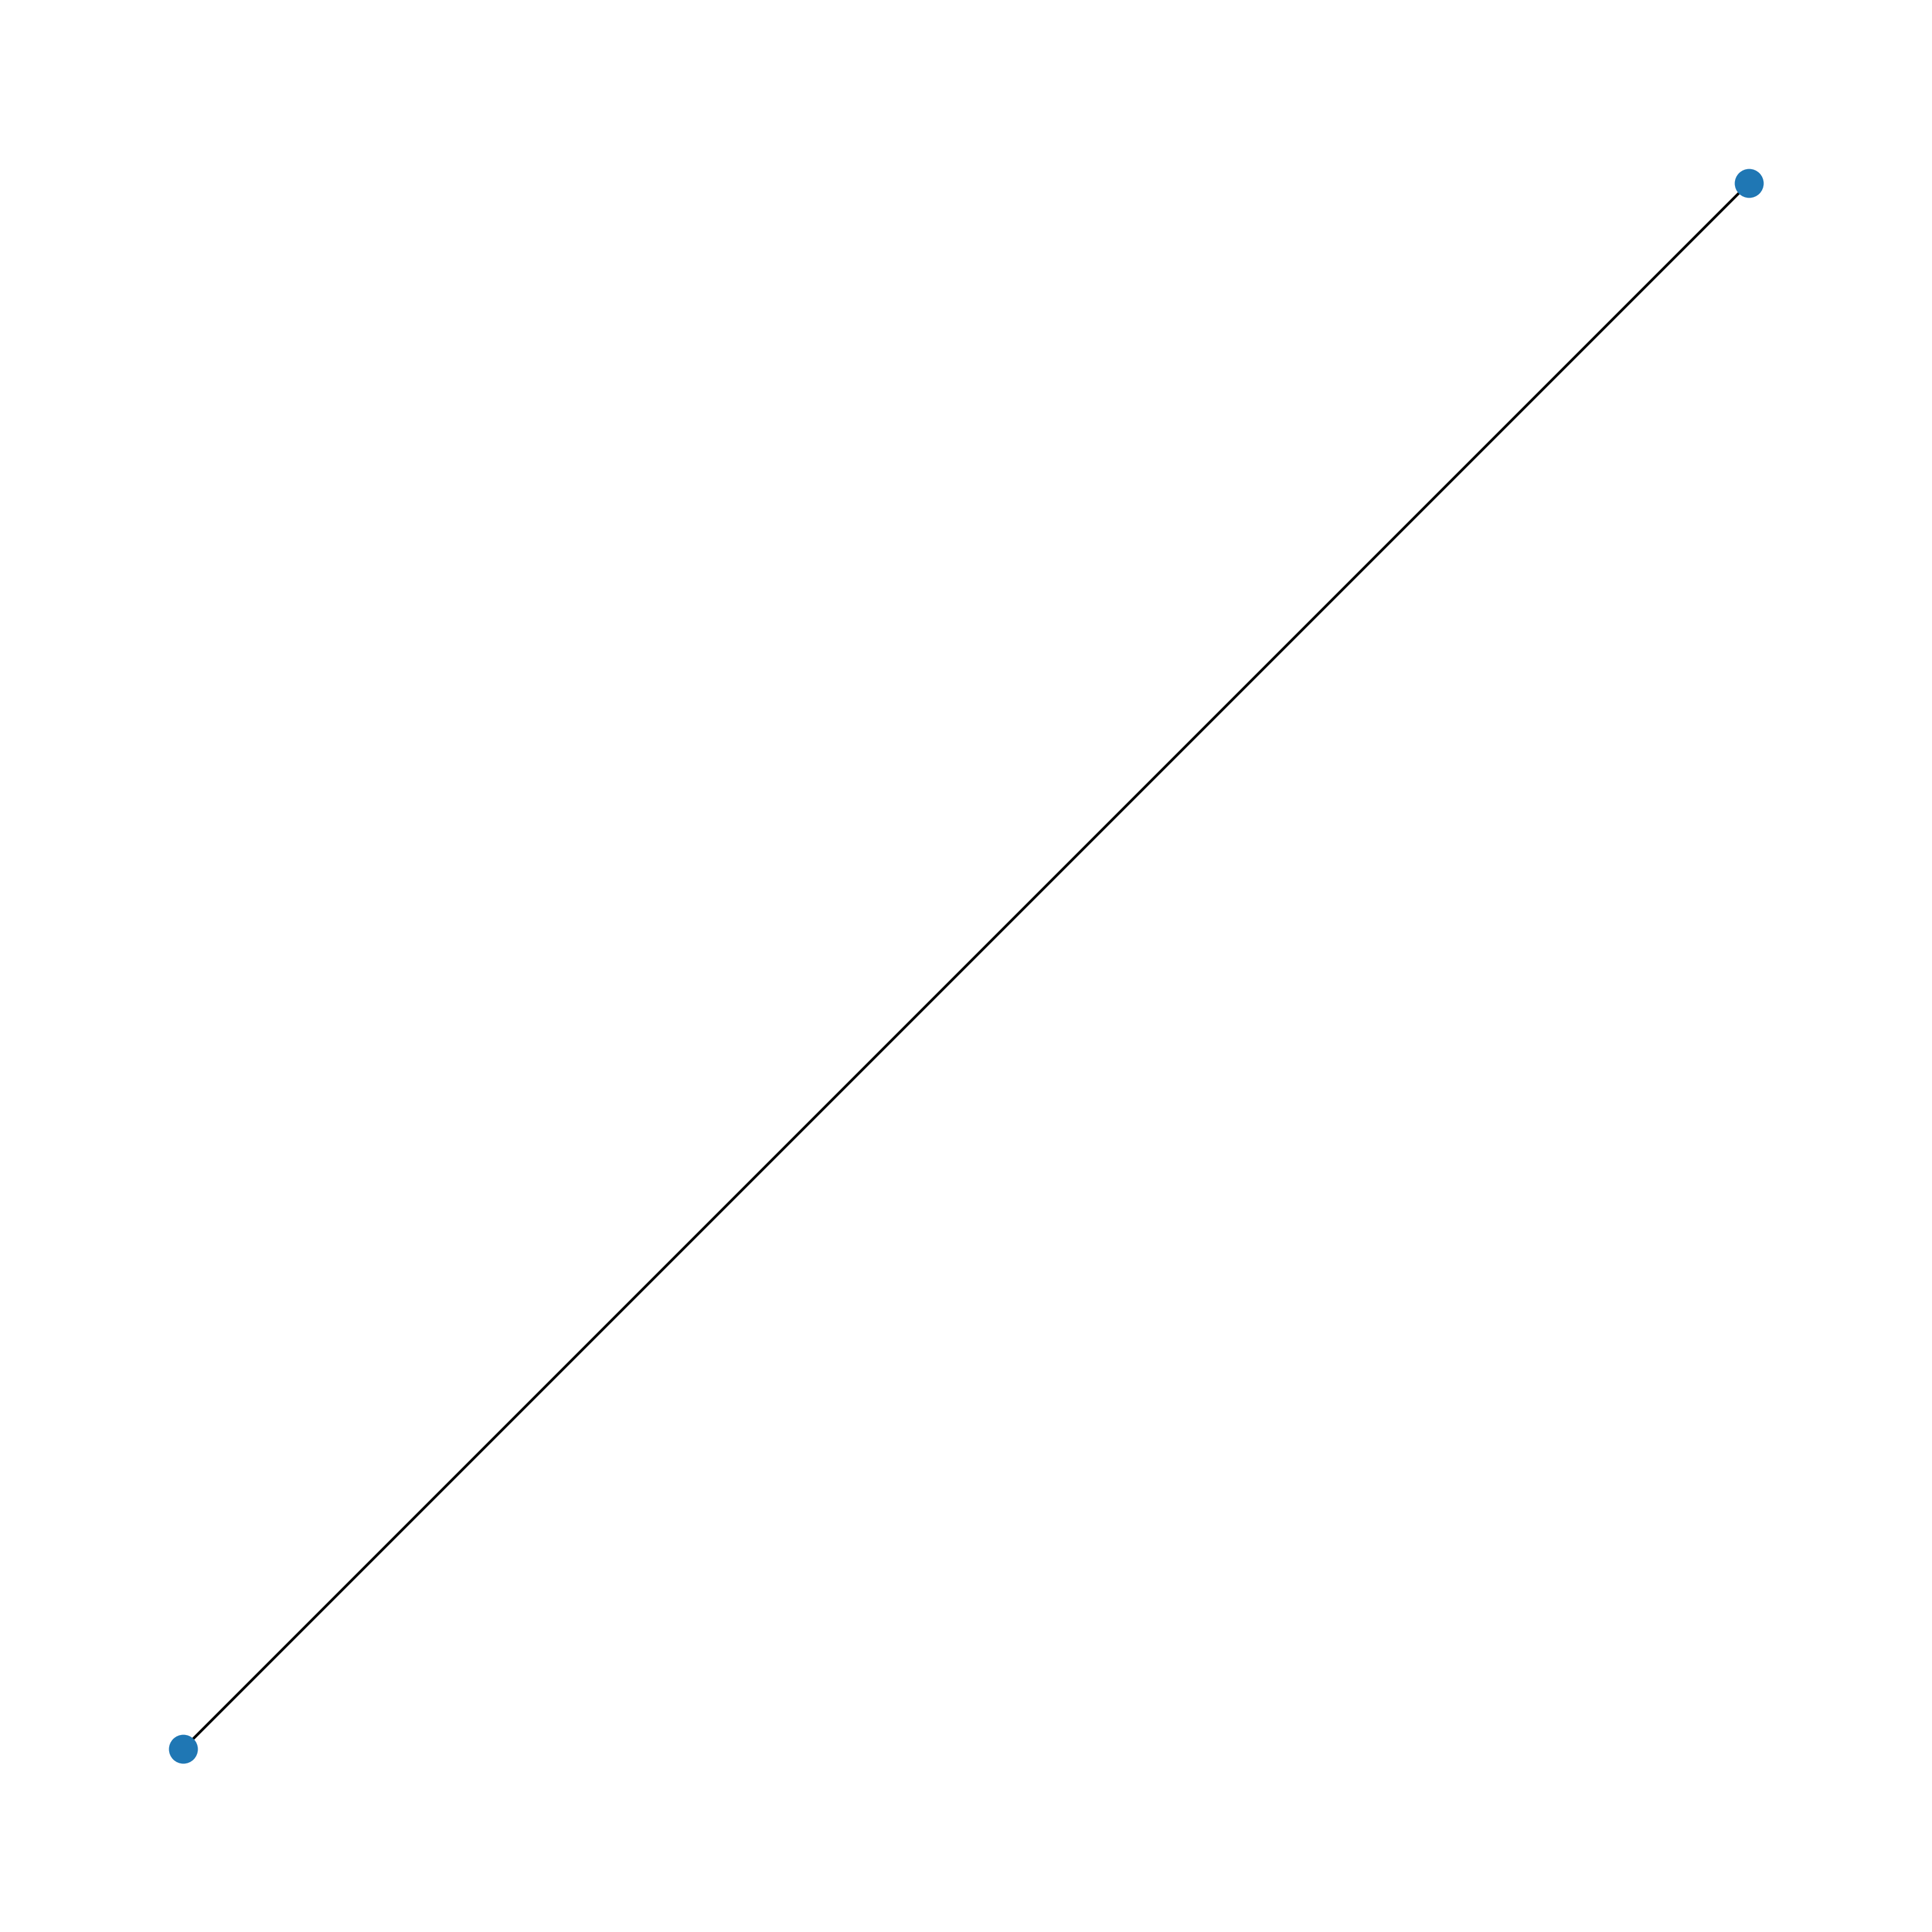

2


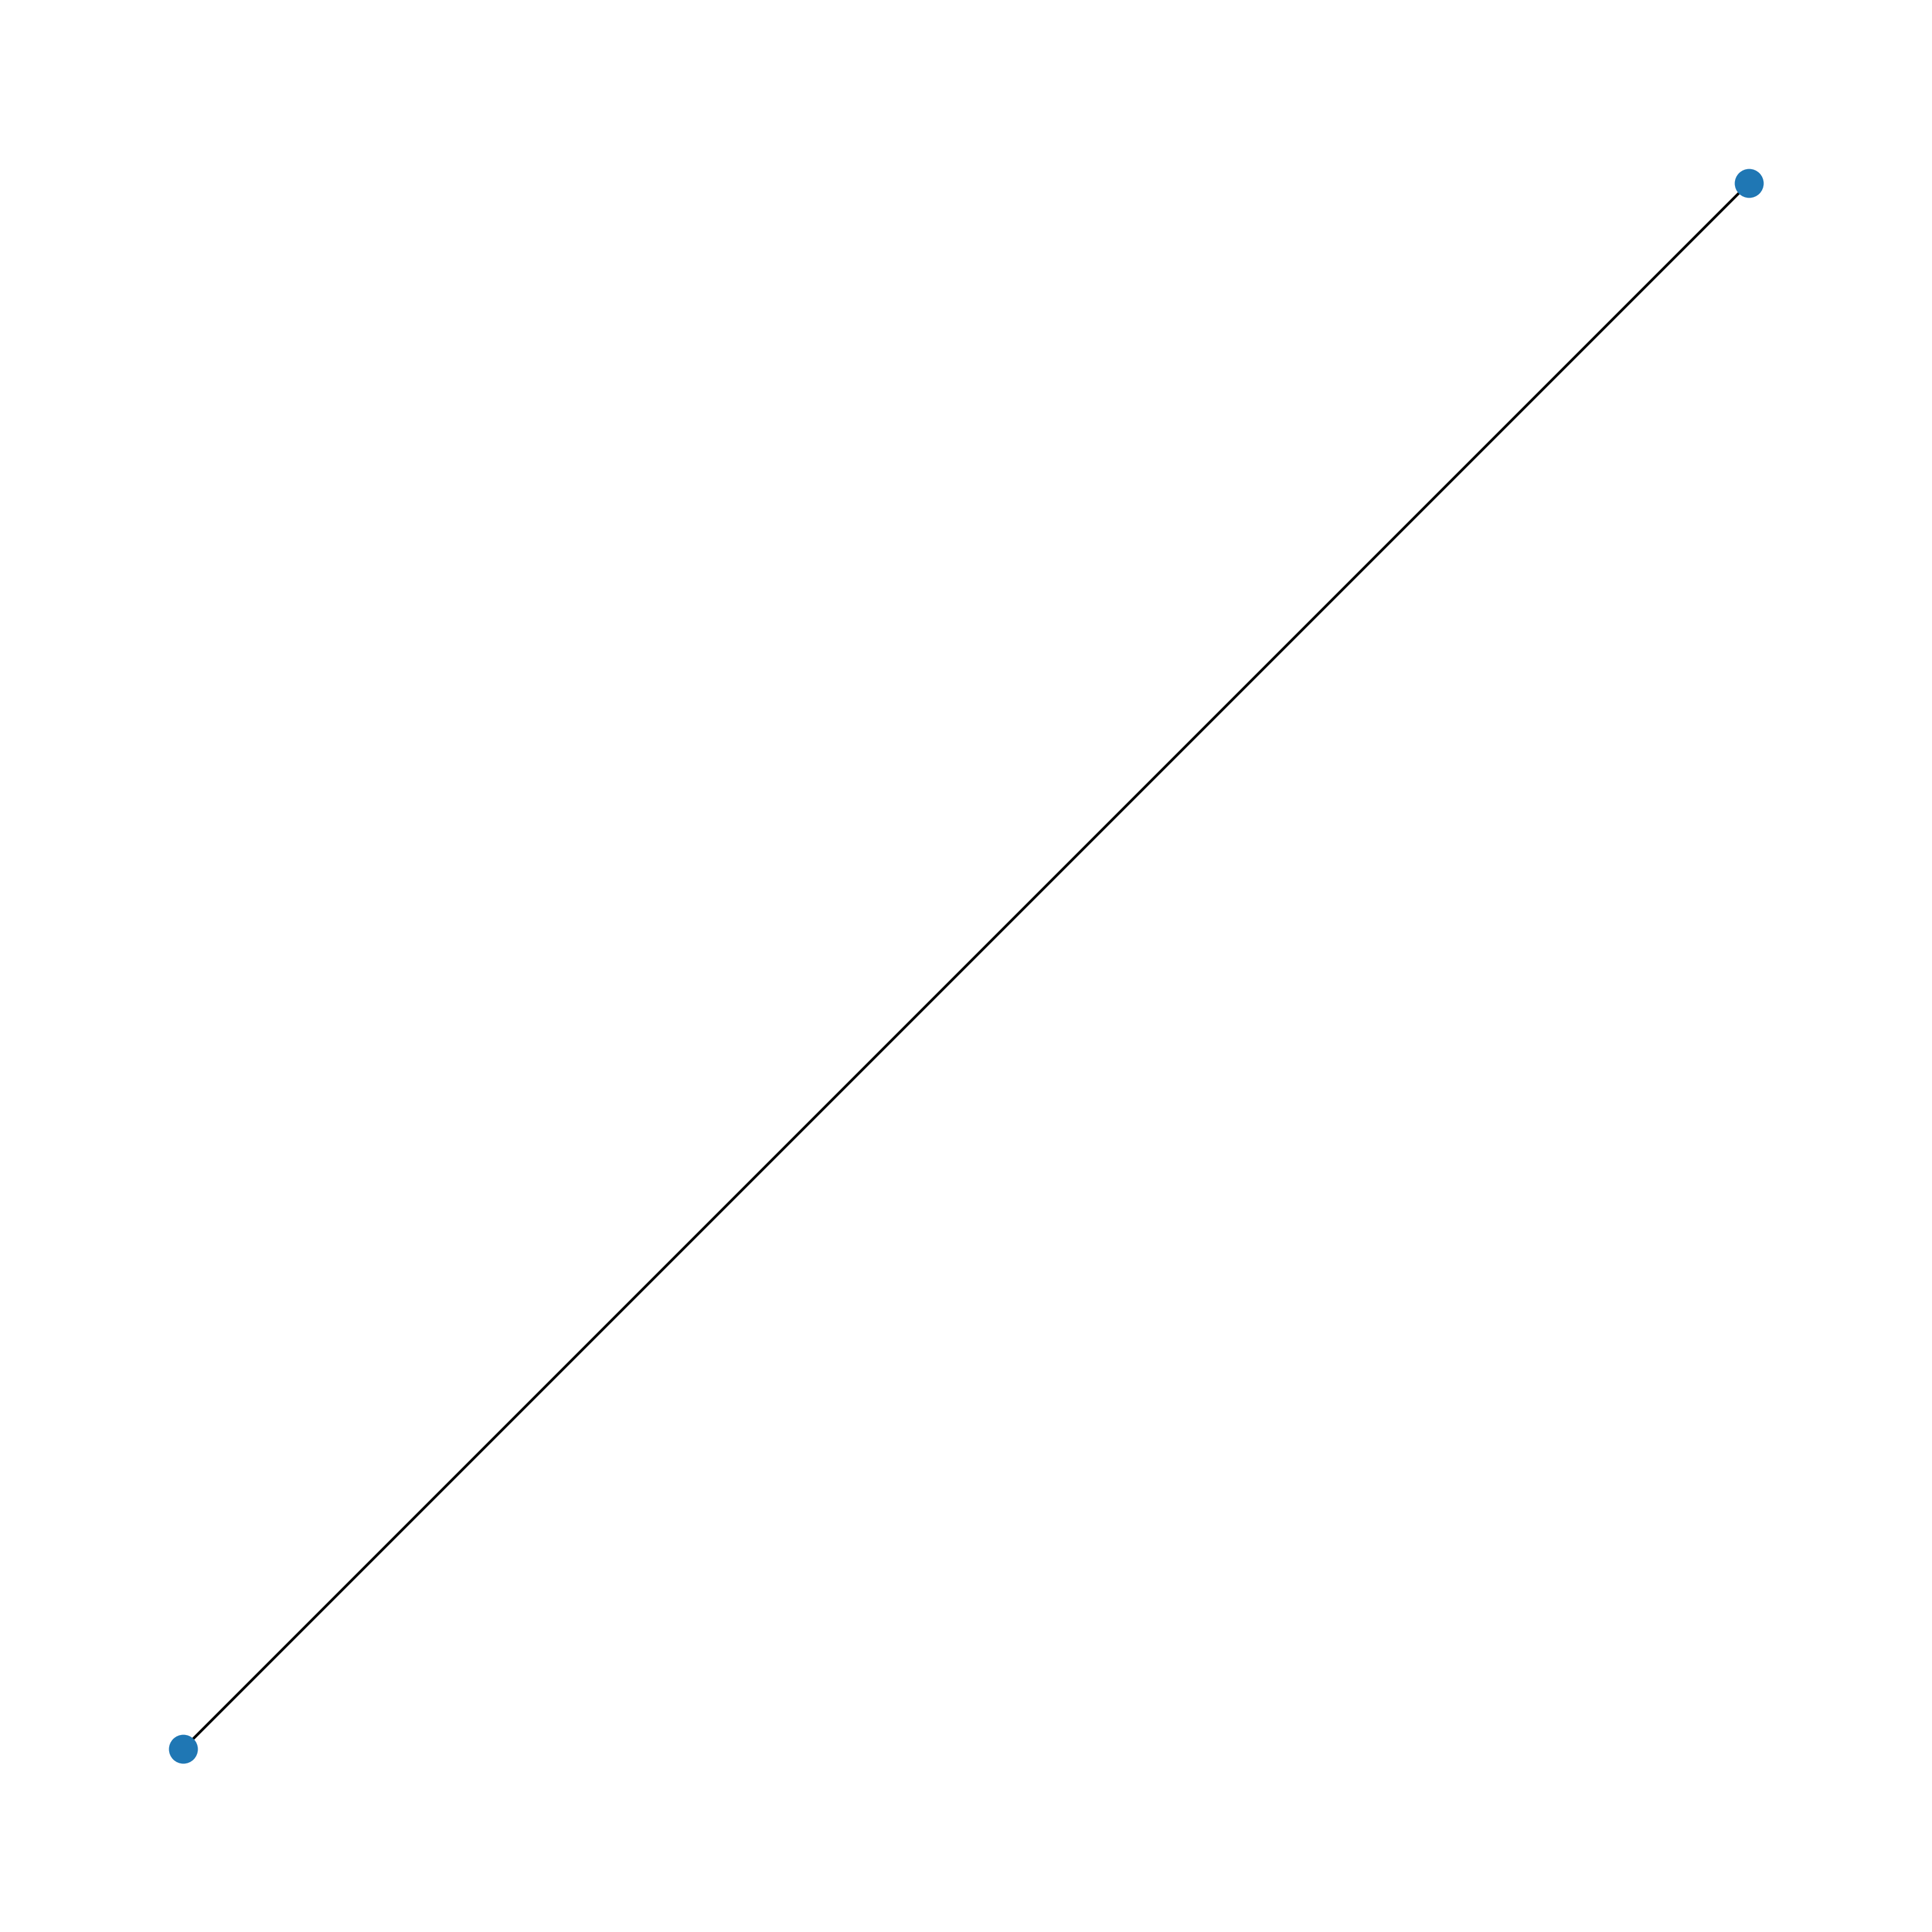

In [26]:
# Get a list of all connected components
connected_components = list(nx.connected_components(G_filtered))

# Create a layout for the graph (you can choose different layouts)
layout = nx.kamada_kawai_layout

# Loop through each connected component and draw it
for i, component in enumerate(connected_components):
    subgraph = G_filtered.subgraph(component)
    print(len(subgraph))
    
    # Create a new figure for each component
    plt.figure(figsize=(10, 10), dpi = 300)
    
    # Draw the subgraph
    nx.draw(subgraph, pos = layout(subgraph), with_labels = False, node_size = 100, node_color=f"C{0}", font_size = 6)
    
    # Add a title for the component
    #plt.title("Network")
    
    plt.savefig(f"network{i}_{tif_file_name}.pdf")
    
    # Show the plot
    plt.show()

In [27]:
# Random graph function in nx
randy = nx.random_reference(G_largest, niter = 10, seed = 5000)

# Calculate the clustering coefficient for each node
clustering_coefficients_randddda = nx.clustering(randy)

# Calculate the average clustering coefficient
average_clustering_coefficient_randddda = sum(clustering_coefficients_randddda.values()) / len(randy)

short_rand = nx.average_shortest_path_length(randy)
glob_rand = nx.global_efficiency(randy)

shortest_ratio = average_shortest / short_rand
effic_ratio = global_efficiency / glob_rand
clust_ratio = average_clustering_coefficient / average_clustering_coefficient_randddda

small_world_quant = clust_ratio / (1 / effic_ratio)

print(f"short_rand: {short_rand}")
print(f"glob_rand: {glob_rand}")

print(f"Average Shortest Path Ratio (short/short_rand): {shortest_ratio}")
print(f"Efficiency Ratio (glob/glob_rand): {effic_ratio}")
print(f"Clustering Ratio (clust/clust_rand): {clust_ratio}")
print(f"S: {small_world_quant}")

short_rand: 1.851233671988389
glob_rand: 0.6218553459119477
Average Shortest Path Ratio (short/short_rand): 1.3296746373970991
Efficiency Ratio (glob/glob_rand): 0.8909906780956109
Clustering Ratio (clust/clust_rand): 1.235601705520545
S: 1.1009096014578437


In [28]:
num_nodesrandy = len(randy.nodes())
num_edgesrandy = len(randy.edges())
average_degreerandy = 2 * num_edgesrandy / num_nodesrandy
print(num_nodesrandy, num_edgesrandy, average_degreerandy)

53 400 15.09433962264151


In [29]:
print(f"Clustering: {average_clustering_coefficient}")
print(f"Random Clustering: {average_clustering_coefficient_randddda}")
print(f"Clustering Ratio (clust/clust_rand): {clust_ratio}")
print(f"S: {small_world_quant}")

Clustering: 0.7182214215664234
Random Clustering: 0.5812726045597718
Clustering Ratio (clust/clust_rand): 1.235601705520545
S: 1.1009096014578437


In [30]:
# No euclidean thresholding, so set to zero
euclidean_threshold = 0

# Output full list of results to .csv file
with open("results_mean_deg_15.csv", "a") as file:
    writer = csv.writer(file)
    writer.writerow([tif_file_name, count, first_component_variability, second_component_variability, correal, prob, euclidean_threshold, len(G_largest.nodes()), len(G_largest.edges()), net_density, mean_degree, standard_degree, min(degrees), max(degrees), mean_correlation_largest_subgraph, global_efficiency, average_clustering_coefficient, average_shortest, glob_rand, average_clustering_coefficient_randddda, short_rand, effic_ratio, clust_ratio, shortest_ratio, small_world_quant, hist_kurtosis_degree, hist_kurtosis_proportion])